# 0. Goals 


1. Importance of class balance in classification.
2. Models with and without feature engineering to address the importance of feature engineering.
3. Analysis of different ML models.
4. Importance of cross-validation and maintaining the history.


# 1. Data Ingestion & Validation

## Data Loading

In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
from datetime import datetime  # Import datetime module
import gzip
import category_encoders as ce
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.options.display.float_format = '{:.2f}'.format


In [352]:
# Reading the input data

num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : datetime.strptime(val, '%y%m%d%H')

train = pd.read_csv('/Users/maver/Documents/Classes/Data Mining/Assignments/DM Project Click-Through Rate Prediction/Code/train.gz', parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values)
train_i = train
train.head(2)

id  click       hour    C1  ...  C18 C19     C20  C21
0  10003539039235338011      0 2014-10-21  1005  ...    0  35  100084   79
1  10004510652136496837      0 2014-10-21  1005  ...    0  39      -1  157

[2 rows x 24 columns]

In [353]:
# Reading the test data.

test = pd.read_csv('/Users/maver/Documents/Classes/Data Mining/Assignments/DM Project Click-Through Rate Prediction/Code/test.gz', parse_dates=['hour'], date_parser=parse_date)
test.head(2)

id       hour    C1  banner_pos  ... C18  C19     C20 C21
0 10000174058809264128.00 2014-10-31  1005           0  ...   3  175  100075  23
1 10000182526920855552.00 2014-10-31  1005           0  ...   0   35  100083  51

[2 rows x 23 columns]

In [354]:
# Submission file for final score.

submission = pd.read_csv('/Users/maver/Documents/Classes/Data Mining/Assignments/DM Project Click-Through Rate Prediction/Code/sampleSubmission.gz')
submission.head(2)

id  click
0  10000174058809263569   0.50
1  10000182526920855428   0.50

## Variable Type Identification & Validation

In [355]:
# info on each column of training dataset.
#  0   id                Unique identifier for each record
#  1   click             Target variable: 1 for click, 0 for no click
#  2   hour              Timestamp of the event
#  3   C1                Anonymous categorical variable
#  4   banner_pos        Position of the banner ad
#  5   site_id           Unique identifier for the site
#  6   site_domain       Domain of the site 
#  7   site_category     Category of the site
#  8   app_id            Unique identifier for the app
#  9   app_domain        Domain of the app
#  10  app_category      Category of the app
#  11  device_id         Unique identifier for the device
#  12  device_ip         IP address of the device
#  13  device_model      Model of the device
#  14  device_type       Type of the device (e.g., mobile, tablet)
#  15  device_conn_type  Type of internet connection
#  16  C14               Anonymous categorical variable
#  17  C15               Anonymous categorical variable
#  18  C16               Anonymous categorical variable
#  19  C17               Anonymous categorical variable
#  20  C18               Anonymous categorical variable
#  21  C19               Anonymous categorical variable
#  22  C20               Anonymous categorical variable
#  23  C21               Anonymous categorical variable
#  24  month             Month extracted from the hour column
#  25  dayofweek         Day of the week extracted from the hour column
#  26  day               Day of the month extracted from the hour column
#  27  hour_time         Hour of the day extracted from the hour column


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

In [356]:
# hour column contains event date with all the details, extracting the same to create different columns.

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head(2)

id  click       hour  ...  dayofweek  day hour_time
0  10003539039235338011      0 2014-10-21  ...          1   21         0
1  10004510652136496837      0 2014-10-21  ...          1   21         0

[2 rows x 28 columns]

In [357]:
# Segregating numerical and categorical variables.

numerical = []
categorical = []

# List of anonymized categorical variables
anonymized_categorical = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20','C21']

for col in train.columns:
    if train[col].dtype == "object" or col in anonymized_categorical:
        categorical.append(col)
    else:
        numerical.append(col)

print("numerical columns = ", numerical)
print("\ncategorical columns = ", categorical)

numerical columns =  ['id', 'click', 'hour', 'banner_pos', 'device_type', 'device_conn_type', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['C1', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


## Data Profiling & Baseline Statistics

In [358]:
# shape of the data read. 

print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

Train dataset: (5000000, 28)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


In [359]:
# Summary statistics for numerical columns
print(train.describe())

                           id      click  ...        day  hour_time
count              5000000.00 5000000.00  ... 5000000.00 5000000.00
mean   9224257902061555712.00       0.17  ...      25.47      11.28
min          7601780064293.00       0.00  ...      21.00       0.00
25%    4617294319861395456.00       0.00  ...      23.00       7.00
50%    9225517812305254400.00       0.00  ...      26.00      11.00
75%   13834439895228459008.00       0.00  ...      28.00      16.00
max   18446743972517787648.00       1.00  ...      30.00      23.00
std    5323948104180993024.00       0.38  ...       2.96       5.95

[8 rows x 19 columns]


Target variable distribution:
click
0   0.83
1   0.17
Name: proportion, dtype: float64


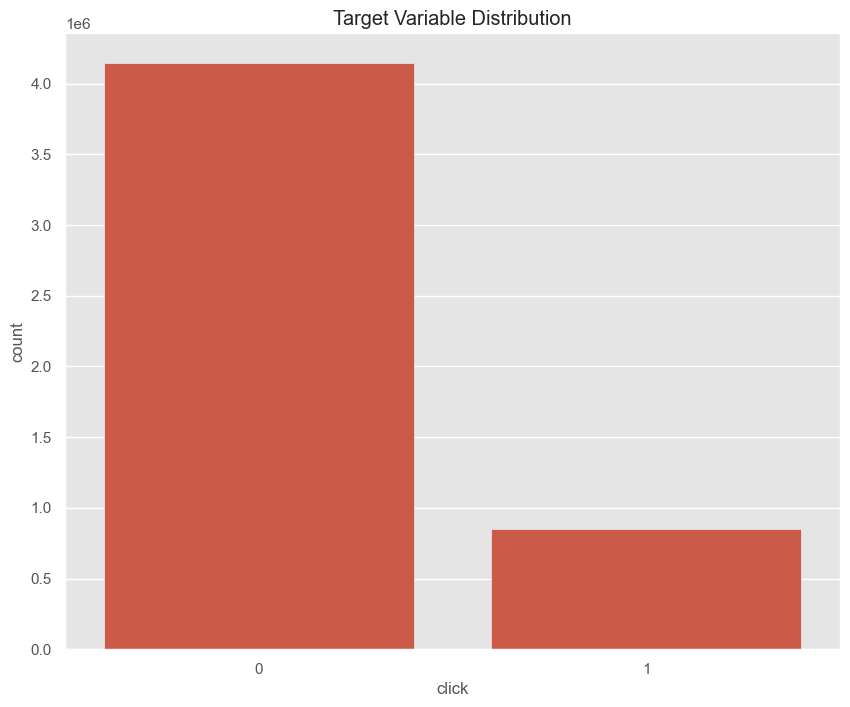

In [360]:
# Distribution of the target variable
print("Target variable distribution:")
print(train['click'].value_counts(normalize=True))

# Visualize the distribution
sns.countplot(x='click', data=train)
plt.title("Target Variable Distribution")
plt.show()

In [ ]:
# Min, Max, and Range for numerical columns
print("Numerical Columns - Min/Max/Range:")
for col in numerical:
    min_val = train[col].min()
    max_val = train[col].max()
    range_val = max_val - min_val
    print(f"{col}: Min = {min_val}, Max = {max_val}, Range = {range_val}")

# Distinct counts for categorical columns
print("\nCategorical Columns - Distinct Counts:")
for col in categorical:
    distinct_count = train[col].nunique()
    print(f"{col}: {distinct_count} distinct values")

Numerical Columns - Min/Max/Range:
id: Min = 7601780064293, Max = 18446743972517787388, Range = 18446736370737723095
click: Min = 0, Max = 1, Range = 1
hour: Min = 2014-10-21 00:00:00, Max = 2014-10-30 23:00:00, Range = 9 days 23:00:00
banner_pos: Min = 0, Max = 7, Range = 7
device_type: Min = 0, Max = 5, Range = 5
device_conn_type: Min = 0, Max = 5, Range = 5
month: Min = 10, Max = 10, Range = 0
dayofweek: Min = 0, Max = 6, Range = 6
day: Min = 21, Max = 30, Range = 9
hour_time: Min = 0, Max = 23, Range = 23

Categorical Columns - Distinct Counts:
C1: 7 distinct values
site_id: 3537 distinct values
site_domain: 4541 distinct values
site_category: 23 distinct values
app_id: 5172 distinct values
app_domain: 323 distinct values
app_category: 30 distinct values
device_id: 597718 distinct values
device_ip: 1904711 distinct values
device_model: 6604 distinct values
C14: 2468 distinct values
C15: 8 distinct values
C16: 9 distinct values
C17: 429 distinct values
C18: 4 distinct values
C19: 67

# 2. Data Pre-Processing (basic)

## Duplicate & Consistency Checks

In [ ]:
# Check for duplicate rows
duplicate_rows = train.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

if duplicate_rows.sum() > 0:
    print("Duplicate rows:")
    print(train[duplicate_rows])

Number of duplicate rows: 0


In [363]:
# Check if 'id' column is unique
if 'id' in train.columns:
    print(f"Number of duplicate IDs: {train['id'].duplicated().sum()}")

Number of duplicate IDs: 0


In [364]:
# Loop through all categorical columns and print unique values
for col in categorical:
    print(f"Column: {col}")
    print(train[col].unique())
    print("-" * 50)

Column: C1
[1005 1010 1002 1008 1007 1001 1012]
--------------------------------------------------
Column: site_id
['1fbe01fe' '543a539e' 'e151e245' ... 'a3d9a1db' '82b4318e' '012662f7']
--------------------------------------------------
Column: site_domain
['f3845767' 'c7ca3108' '7e091613' ... 'a82e7632' 'e05edb43' 'df5df967']
--------------------------------------------------
Column: site_category
['28905ebd' '3e814130' 'f028772b' '50e219e0' '335d28a8' '76b2941d'
 '72722551' '0569f928' '75fa27f6' 'f66779e6' 'c0dd3be3' 'bcf865d9'
 'a818d37a' '5378d028' '70fb0e29' '9ccfa2ea' '42a36e14' '8fd0aea4'
 'dedf689d' 'e787de0e' '110ab22d' 'da34532e' 'c706e647']
--------------------------------------------------
Column: app_id
['ecad2386' 'ffc6ffd0' '0acbeaa3' ... 'f5436021' '008e6bde' '5d821cf4']
--------------------------------------------------
Column: app_domain
['7801e8d9' '45a51db4' '2347f47a' 'ad63ec9b' 'd9b5648e' '82e27996'
 '5c5a694b' '813f3323' 'ae637522' 'aefc06bd' 'b5f3b24a' '33da2e7

In [365]:
# Check unique values in categorical columns
for col in train.select_dtypes(include=['object']).columns:
    print(f"{col}: {train[col].nunique()} unique values")

site_id: 3537 unique values
site_domain: 4541 unique values
site_category: 23 unique values
app_id: 5172 unique values
app_domain: 323 unique values
app_category: 30 unique values
device_id: 597718 unique values
device_ip: 1904711 unique values
device_model: 6604 unique values


## Missing-Value Analysis & Imputation

In [ ]:
# No null values found in the dataset.
train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour_time           0
dtype: int64

## Duplicate & Near-Duplicate Removal N/A

## Outlier Detection + Capping Outliers

In [ ]:
# Detect outliers in categorical columns based on frequency
for col in categorical:
    print(f"Column: {col}")
    value_counts = train[col].value_counts(normalize=True)
    print("Value counts (as percentage):")
    print(value_counts)

    rare_categories = value_counts[value_counts < 0.01]
    print("Rare categories (less than 1%):")
    print(rare_categories)
    print("-" * 50)

Column: C1
Value counts (as percentage):
C1
1005   0.92
1002   0.05
1010   0.02
1012   0.00
1007   0.00
1001   0.00
1008   0.00
Name: proportion, dtype: float64
Rare categories (less than 1%):
C1
1012   0.00
1007   0.00
1001   0.00
1008   0.00
Name: proportion, dtype: float64
--------------------------------------------------
Column: site_id
Value counts (as percentage):
site_id
85f751fd   0.36
1fbe01fe   0.16
e151e245   0.07
d9750ee7   0.02
5b08c53b   0.02
           ... 
819adc9f   0.00
500f3527   0.00
e5a0de9c   0.00
2aa30f4e   0.00
012662f7   0.00
Name: proportion, Length: 3537, dtype: float64
Rare categories (less than 1%):
site_id
b7e9786d   0.01
5ee41ff2   0.01
6399eda6   0.01
5bcf81a2   0.01
6256f5b4   0.01
           ... 
819adc9f   0.00
500f3527   0.00
e5a0de9c   0.00
2aa30f4e   0.00
012662f7   0.00
Name: proportion, Length: 3529, dtype: float64
--------------------------------------------------
Column: site_domain
Value counts (as percentage):
site_domain
c4e18dd6   0.37
f38

In [ ]:
# Remove 'id' and 'click' from the numerical list when assigning to outlier_columns
outlier_columns = [col for col in numerical if col not in ['id', 'click','hour']]

# Proceed with outlier detection for the remaining numerical columns
for col in outlier_columns:
    lower_limit = train[col].quantile(0.02)  # Calculate the 2nd percentile
    upper_limit = train[col].quantile(0.98)  # Calculate the 98th percentile
    
    print(f"{col}: 2nd percentile = {lower_limit}, 98th percentile = {upper_limit}")
    
    # Flag high-end and low-end outliers
    high_outliers = train[train[col] > upper_limit]
    low_outliers = train[train[col] < lower_limit]
    
    print(f"Number of high-end outliers in {col}: {len(high_outliers)}")
    print(f"Number of low-end outliers in {col}: {len(low_outliers)}")
    print("-" * 50)

banner_pos: 2nd percentile = 0.0, 98th percentile = 1.0
Number of high-end outliers in banner_pos: 8890
Number of low-end outliers in banner_pos: 0
--------------------------------------------------
device_type: 2nd percentile = 0.0, 98th percentile = 4.0
Number of high-end outliers in device_type: 15787
Number of low-end outliers in device_type: 0
--------------------------------------------------
device_conn_type: 2nd percentile = 0.0, 98th percentile = 3.0
Number of high-end outliers in device_conn_type: 5178
Number of low-end outliers in device_conn_type: 0
--------------------------------------------------
month: 2nd percentile = 10.0, 98th percentile = 10.0
Number of high-end outliers in month: 0
Number of low-end outliers in month: 0
--------------------------------------------------
dayofweek: 2nd percentile = 0.0, 98th percentile = 6.0
Number of high-end outliers in dayofweek: 0
Number of low-end outliers in dayofweek: 0
--------------------------------------------------
day: 

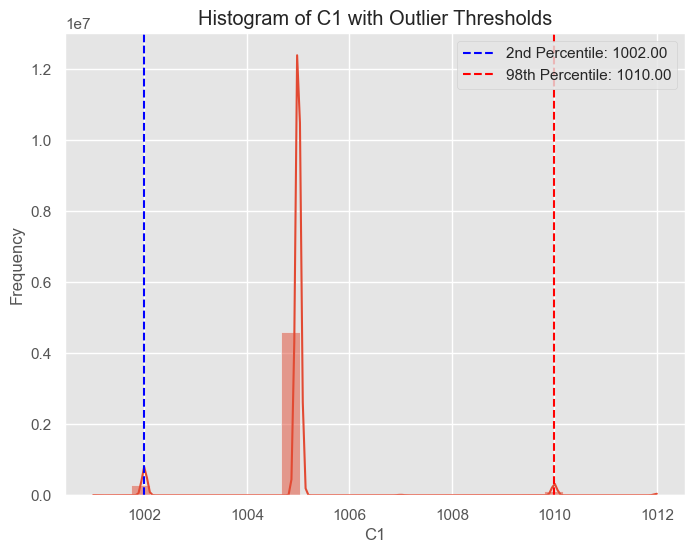

Number of low-end outliers: 1158
Number of high-end outliers: 14237


In [ ]:
# Calculate the 2nd and 98th percentiles
lower_limit = train['C1'].quantile(0.02)
upper_limit = train['C1'].quantile(0.98)

# Plot histogram with the 2nd and 98th percentiles marked
plt.figure(figsize=(8, 6))
sns.histplot(train['C1'], kde=True, bins=30)
plt.axvline(lower_limit, color='blue', linestyle='--', label=f"2nd Percentile: {lower_limit:.2f}")
plt.axvline(upper_limit, color='red', linestyle='--', label=f"98th Percentile: {upper_limit:.2f}")
plt.title("Histogram of C1 with Outlier Thresholds")
plt.xlabel("C1")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Identify outliers
low_outliers = train[train['C1'] < lower_limit]
high_outliers = train[train['C1'] > upper_limit]

print(f"Number of low-end outliers: {len(low_outliers)}")
print(f"Number of high-end outliers: {len(high_outliers)}")

In [370]:
# Verify statistics
print(train[outlier_columns].describe())

       banner_pos  device_type  ...        day  hour_time
count  5000000.00   5000000.00  ... 5000000.00 5000000.00
mean         0.29         1.01  ...      25.47      11.28
std          0.51         0.53  ...       2.96       5.95
min          0.00         0.00  ...      21.00       0.00
25%          0.00         1.00  ...      23.00       7.00
50%          0.00         1.00  ...      26.00      11.00
75%          1.00         1.00  ...      28.00      16.00
max          7.00         5.00  ...      30.00      23.00

[8 rows x 7 columns]


In [371]:
# Capping numerical outliers below the 2nd percentile and above the 98th percentile
for col in outlier_columns:  # Loop through numerical columns
    lower_limit = train[col].quantile(0.02)  # 2nd percentile
    upper_limit = train[col].quantile(0.98)  # 98th percentile
    
    # Replace values below the 2nd percentile with the lower limit
    train[col] = np.where(train[col] < lower_limit, lower_limit, train[col])
    
    # Replace values above the 98th percentile with the upper limit
    train[col] = np.where(train[col] > upper_limit, upper_limit, train[col])

In [372]:
# TODO deal with categorical outliers if time persists

In [373]:
# Verify changes
print(train[outlier_columns].describe())

       banner_pos  device_type  ...        day  hour_time
count  5000000.00   5000000.00  ... 5000000.00 5000000.00
mean         0.28         1.01  ...      25.47      11.28
std          0.45         0.50  ...       2.96       5.95
min          0.00         0.00  ...      21.00       0.00
25%          0.00         1.00  ...      23.00       7.00
50%          0.00         1.00  ...      26.00      11.00
75%          1.00         1.00  ...      28.00      16.00
max          1.00         4.00  ...      30.00      23.00

[8 rows x 7 columns]


# 3. Model Pipeline (Baseline)

## Train-Validation-Test Split Setup

In [400]:
# prep X y
train.rename(columns={'click': 'y',},
          inplace=True, errors='raise')

KeyError: "['click'] not found in axis"

In [ ]:

# Sample 10% of the data
sampled_data = train.sample(frac=0.1, random_state=42)

# Sort the data by the 'hour' column to maintain temporal order
sampled_data = sampled_data.sort_values(by='hour')
sampled_data.drop(['hour'], axis = 1, inplace = True) 
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

y
0   0.83
1   0.17
Name: proportion, dtype: float64




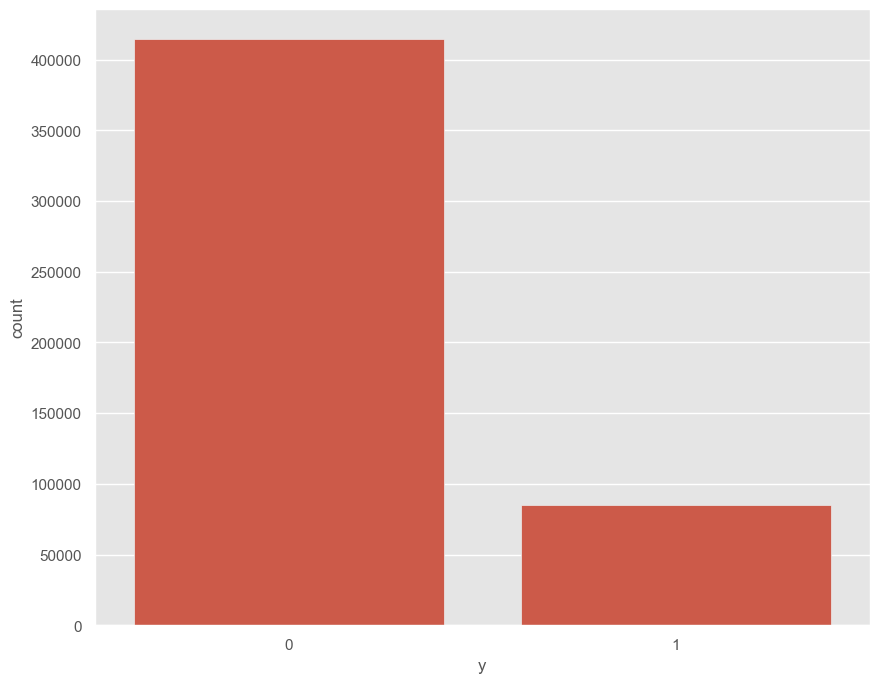

In [ ]:
# After taking the sample of data, still the ratio of output remains same.

print(sampled_data.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

### Categorical Encoding (Basic)

In [ ]:
# target encoding to convert categorical variables into a statistic(mean) representing the target variable
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

id    C1  banner_pos  ...  dayofweek   day  hour_time
4094  14725329914147110295  1005        0.00  ...       1.00 21.00       0.00
771     108846178740989759  1005        1.00  ...       1.00 21.00       0.00

[2 rows x 26 columns]

In [ ]:
# acknowledges time leak since data is sorted by hour and test data comes after train

# Define the split point (e.g., 80% train, 20% test)
split_point = int(len(X) * 0.8)

# Create train and test sets
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Print the sizes to verify
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 400000, Test size: 100000


## Building basic models [no feature engineering]
 1. in this no feature engineering is done apart from removing click column.
 2. We will run multiple models 
      a. Dummy Classifier
      b. Logistic regression [for explainability and finding linear relationship]
      c. Decision tree classifier [for explainability and also for non-linear relation]
      d. Random forest classifier [for accuracy and improving the model] 
      e. XGBClassifier
      f. KNN
      g. Bagging Classifier

### Evaluation Functions

In [401]:
# this function helps in evaluating the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix, f1

In [402]:
# Plots the ROC curve and returns false positive rate, true positive rate, and thresholds. 

def draw_roc(model, X_test, actual):
    probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {type(model).__name__}')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [403]:
# Returns the crossvalidation score for given number of n folds. 

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    print("crossval output:",crossvalidation)
    return crossvalidation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    """
    Stores the results of the model evaluation using time-series-aware cross-validation.
    """
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=folds)
    crossvalidation_scores = []

    # Perform time-series-aware cross-validation
    for train_index, val_index in tscv.split(xtrain):
        X_train_fold, X_val_fold = xtrain.iloc[train_index], xtrain.iloc[val_index]
        y_train_fold, y_val_fold = ytrain.iloc[train_index], ytrain.iloc[val_index]
        
        # Fit the model on the training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Evaluate on the validation fold
        val_score = model.score(X_val_fold, y_val_fold)
        crossvalidation_scores.append(val_score)

    # Calculate mean and variance of cross-validation scores
    crossvalidation_mean = sum(crossvalidation_scores) / len(crossvalidation_scores)
    crossvalidation_variance = np.var(crossvalidation_scores)

    # Evaluate the model on the test set
    accuracy_test, cm_test, f1_test = model_eval(model, xtest, ytest)
    TP = cm_test[1, 1]  
    TN = cm_test[0, 0]  
    FP = cm_test[0, 1] 
    FN = cm_test[1, 0]  
    recall_test = TP / (TP + FP) if (TP + FP) > 0 else 0
    precision_test = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Evaluate the model on the training set
    accuracy_train, cm_train, f1_train = model_eval(model, xtrain, ytrain)
    TP = cm_train[1, 1]  
    TN = cm_train[0, 0]  
    FP = cm_train[0, 1]  
    FN = cm_train[1, 0]  
    recall_train = TP / (TP + FP) if (TP + FP) > 0 else 0
    precision_train = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Store results in a DataFrame
    entry = {
        'Model': [name],
        'Accuracy_train': [accuracy_train],
        'recall_train': [recall_train],
        'precision_train': [precision_train],
        'f1_train': [f1_train],
        'Accuracy_test': [accuracy_test],
        'recall_test': [recall_test],
        'precision_test': [precision_test],
        'f1_test': [f1_test],
        'CrossVal_Mean': [crossvalidation_mean],
        'CrossVal_Variance': [crossvalidation_variance]
    }
    result = pd.DataFrame(entry)
    return result

### Dummy classifier for verification
Dummy classifier helps in baseling the model performace w.r.t dominanat class. 

accuracy test: 0.8384
confusion mat test:
 [[83840     0]
 [16160     0]]
f1 test: 0.0


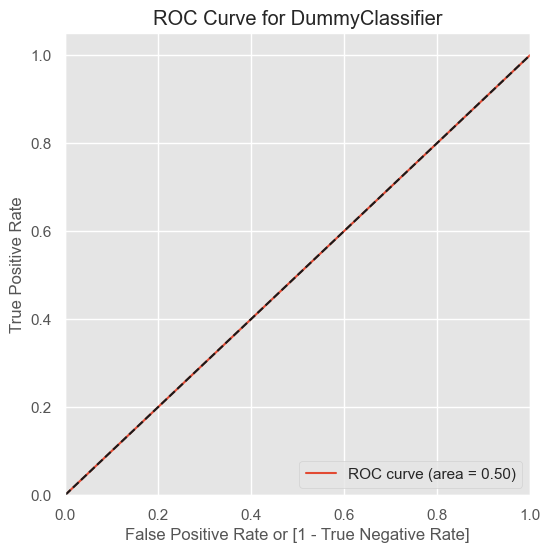

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00

[1 rows x 11 columns]

In [405]:
# Running model against training + collect results
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_train, y_train)
accuracy_test, cnf_matrix_test, f1_test  = model_eval(dummy_clf, X_test, y_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy_clf, 5)
draw_roc(dummy_clf, X_test, y_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

### Basic Logistic regression model

In [406]:
# MinMaxScaler used to scale each feature in the dataset to a specified range (0-1)
# Scale feature values for training data set

# Separate numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

# Apply MinMaxScaler to numerical columns
scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [407]:
# Train model
LogReg_model = LogisticRegression(penalty='l2', solver = "saga")
LogReg_model.fit(X_train, y_train)

LogisticRegression(solver='saga')

accuracy test: 0.93557
confusion mat test:
 [[81761  2079]
 [ 4364 11796]]
f1 test: 0.7854836024637921


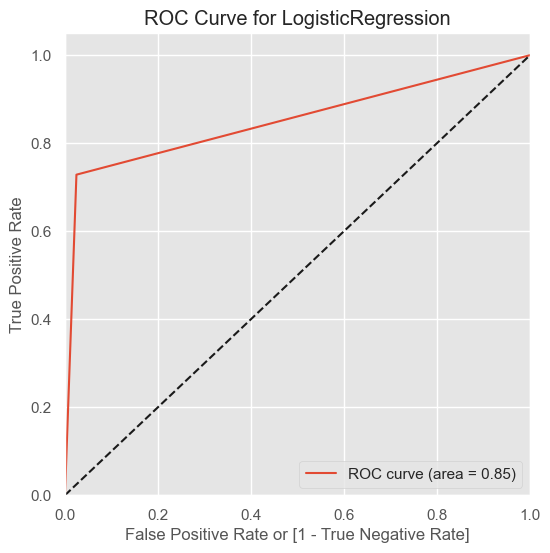

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.93  ...           0.93               0.00

[2 rows x 11 columns]

In [408]:
# Running model against training + collect results
y_pred = LogReg_model.predict(X_test)
accuracy_test, cnf_matrix_test,f1_test = model_eval(LogReg_model, X_test, y_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("logistic regres", y_train, X_train, y_test, X_test, LogReg_model, 5)
draw_roc(LogReg_model, X_test, y_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

###  Decision tree classifier

In [409]:
# decision tree doesn't require feature scaling, will use the raw features directly 
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
X_train.head(2)

id    C1  banner_pos  ...  dayofweek   day  hour_time
4094  14725329914147110295  1005        0.00  ...       1.00 21.00       0.00
771     108846178740989759  1005        1.00  ...       1.00 21.00       0.00

[2 rows x 26 columns]

accuracy test: 0.92122
confusion mat test:
 [[79441  4399]
 [ 3479 12681]]
f1 test: 0.7629963898916968


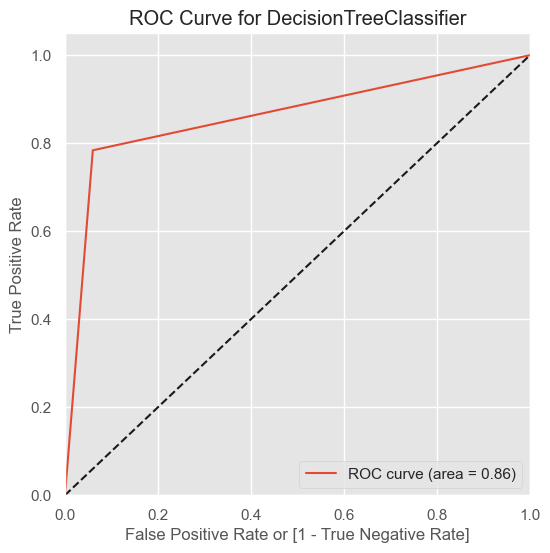

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.93  ...           0.93               0.00
2     Decision Tree            0.99  ...           0.91               0.00

[3 rows x 11 columns]

In [410]:
# Running model against training + collect results
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy_test, cnf_matrix_test, f1_test = model_eval(dt_basic, X_test, y_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("Decision Tree", y_train, X_train, y_test, X_test, dt_basic, 5)
draw_roc(dt_basic, X_test, y_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome


### Random forest classifier


accuracy test: 0.9417
confusion mat test:
 [[82551  1289]
 [ 4541 11619]]
f1 test: 0.7994358056969864


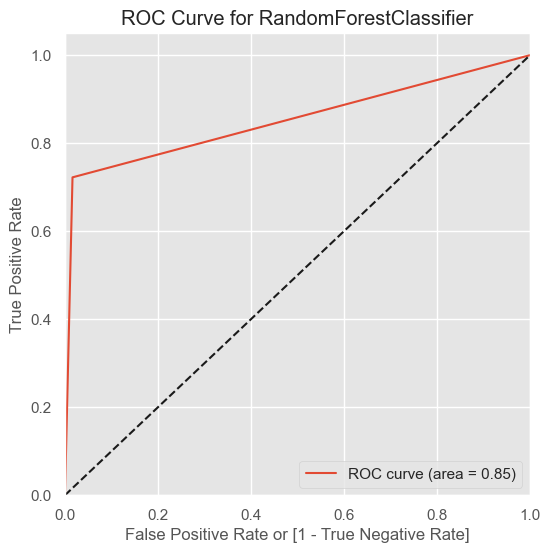

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.93  ...           0.93               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00

[4 rows x 11 columns]

In [411]:
# Running model against training + collect results
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy_test, cnf_matrix_test, f1_test = model_eval(model_rf, X_test, y_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("Random Forest", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome


### XGBoost


In [412]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight
negative_count = y_train.value_counts()[0]
positive_count = y_train.value_counts()[1]
scale_pos_weight = negative_count / positive_count

In [413]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Accuracy on test data: 0.90093
Confusion Matrix on test data:
 [[74987  8853]
 [ 1054 15106]]
f1 test: 0.753059647548543


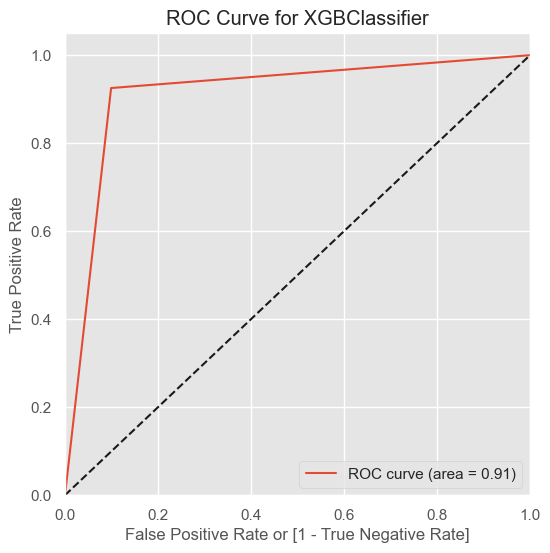

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.93  ...           0.93               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00
4           XGBoost            0.90  ...           0.90               0.00

[5 rows x 11 columns]

In [414]:
# Running model against training + collect results
accuracy_test, cnf_matrix_test, f1_test = model_eval(xgb_model, X_test, y_test)
print("Accuracy on test data:", accuracy_test)
print("Confusion Matrix on test data:\n", cnf_matrix_test)
print("f1 test:",f1_test)

# Store results
temp = store_results("XGBoost", y_train, X_train, y_test, X_test, xgb_model, 5)

# Plot ROC curve
draw_roc(xgb_model, X_test, y_test)

# Append results to the outcome DataFrame
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

### KNN


In [415]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='brute',
    metric='minkowski',  # Or 'manhattan'
    p=2  # Euclidean distance
)

# Train the KNN model on the imbalanced dataset
knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', weights='distance')

Accuracy on test data: 0.76307
Confusion Matrix on test data:
 [[74445  9395]
 [14298  1862]]
f1 test: 0.13582813582813583


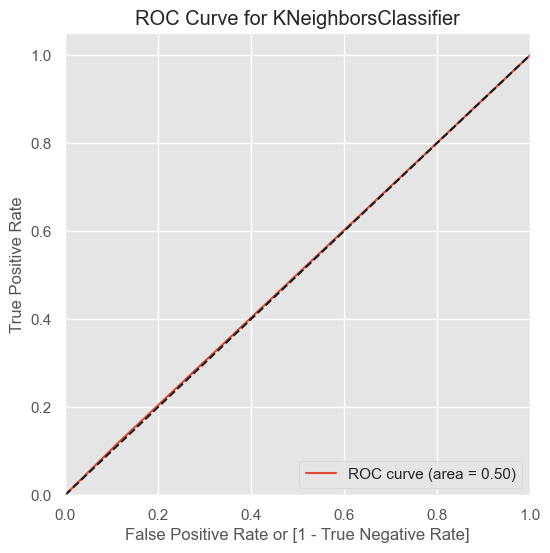

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.93  ...           0.93               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00
4           XGBoost            0.90  ...           0.90               0.00
5               KNN            0.96  ...           0.75               0.00

[6 rows x 11 columns]

In [ ]:
# Running model against training + collect results
accuracy_test, cnf_matrix_test, f1_test = model_eval(knn_model, X_test, y_test)
print("Accuracy on test data:", accuracy_test)
print("Confusion Matrix on test data:\n", cnf_matrix_test)
print("f1 test:",f1_test)

# Store results in the outcome DataFrame
temp = store_results("KNN", y_train, X_train, y_test, X_test, knn_model, 5)

# Plot the ROC curve
draw_roc(knn_model, X_test, y_test)

# Append results to the outcome DataFrame
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

### Bagging Classifier


In [417]:
from sklearn.ensemble import BaggingClassifier
Bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
Bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

Accuracy on test data: 0.93669
Confusion Matrix on test data:
 [[81866  1974]
 [ 4357 11803]]
f1 test: 0.7885225640511743


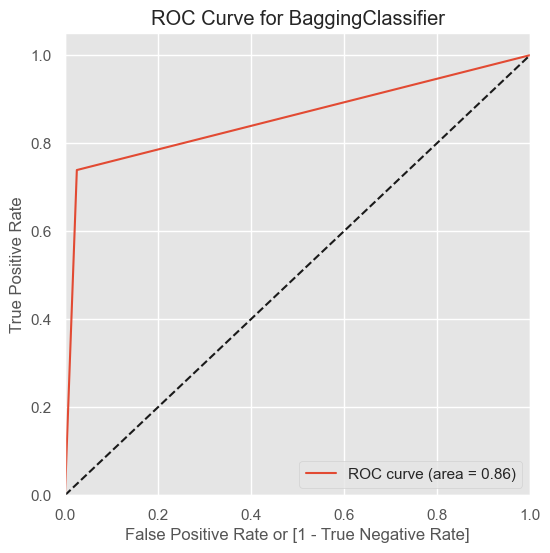

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.93  ...           0.93               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00
4           XGBoost            0.90  ...           0.90               0.00
5               KNN            0.96  ...           0.75               0.00
6           Bagging            0.98  ...           0.93               0.00

[7 rows x 11 columns]

In [418]:
# Running model against training + collect results
accuracy_test, cnf_matrix_test, f1_test = model_eval(Bagging_model, X_test, y_test)
print("Accuracy on test data:", accuracy_test)
print("Confusion Matrix on test data:\n", cnf_matrix_test)
print("f1 test:",f1_test)

# Store results in the outcome DataFrame
temp = store_results("Bagging", y_train, X_train, y_test, X_test, Bagging_model, 5)

# Plot the ROC curve
draw_roc(Bagging_model, X_test, y_test)

# Append results to the outcome DataFrame
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

## Analysis

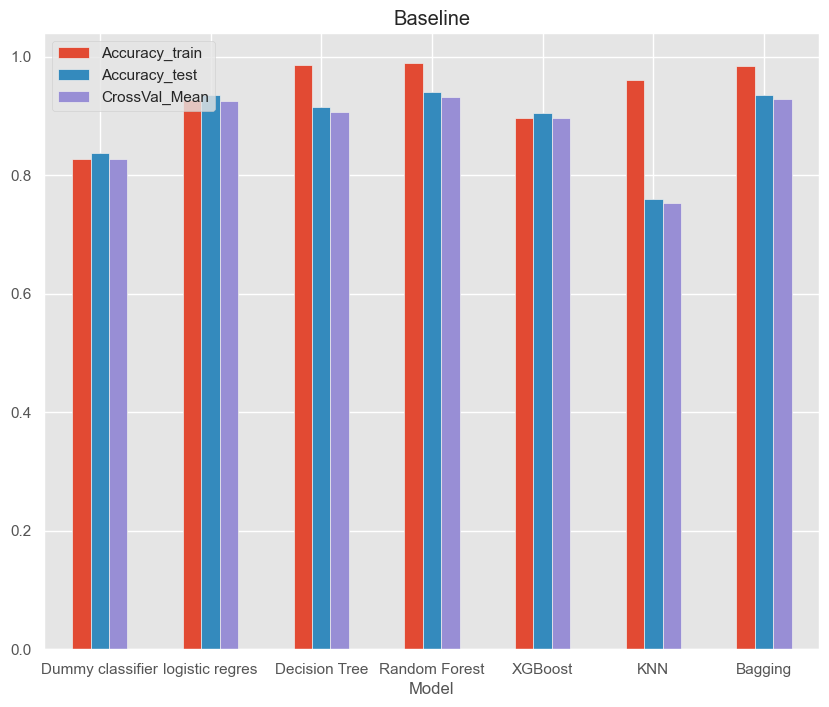

In [ ]:
# Conclusion for imbalanced data
plt.rcParams["figure.figsize"] = (10, 8)
outcome.plot(x='Model', y=['Accuracy_train', 'Accuracy_test', 'CrossVal_Mean'], kind="bar")
plt.title("Baseline")  
plt.xticks(rotation=0)
plt.show()

### observations:



# 4. Exploratory Data Analysis/Mining (EDA)

## Univariate Analysis

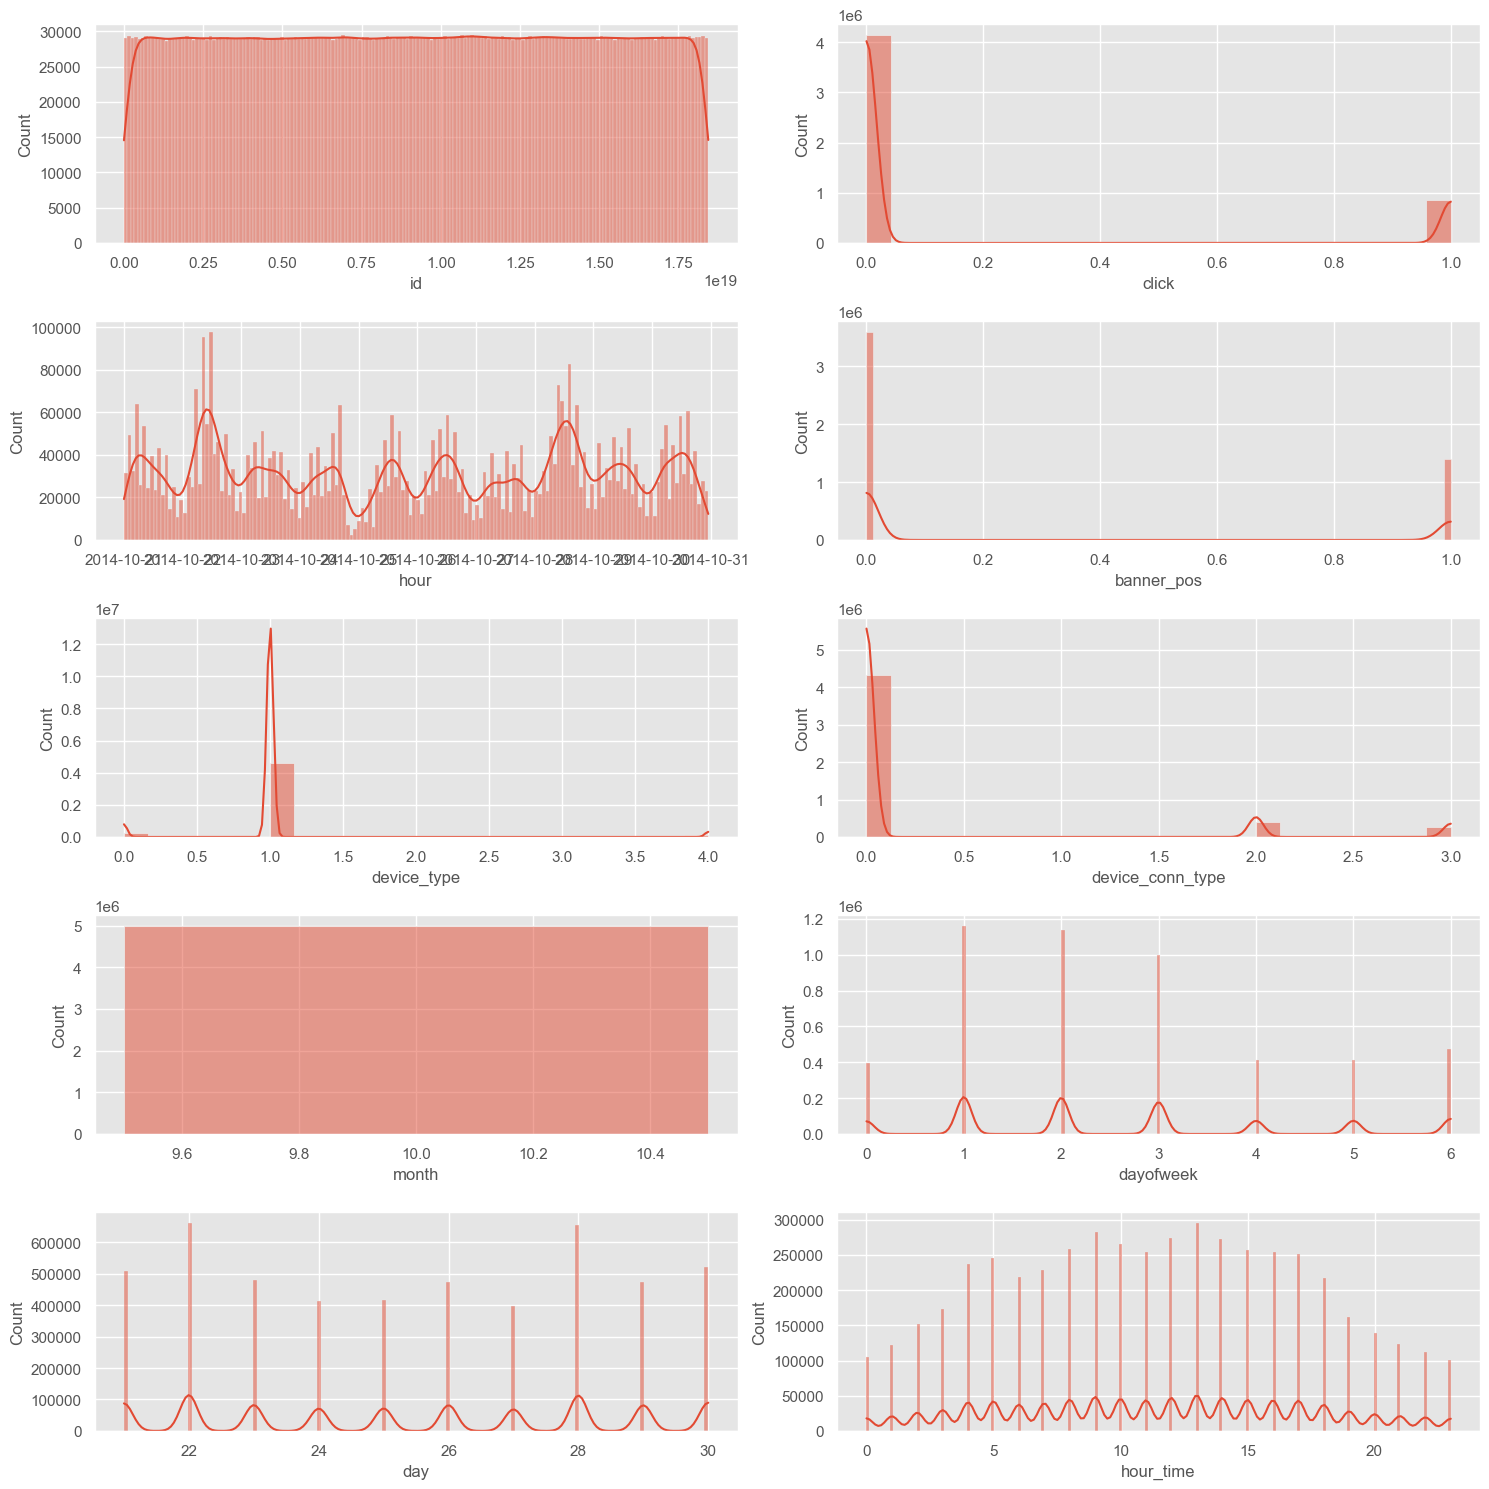

In [ ]:
# The code below will plot histograms for all numerical columns 

n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)])

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.histplot(train[numerical[i]], kde=True)  # kde=True adds a Kernel Density Estimate curve

plt.tight_layout()
plt.show()


1. All categorical variables have lot of unique values in it, one hot encoding is not a scalable approach. 
2. we will go with label encoding and scaling approach is a better idea for this.

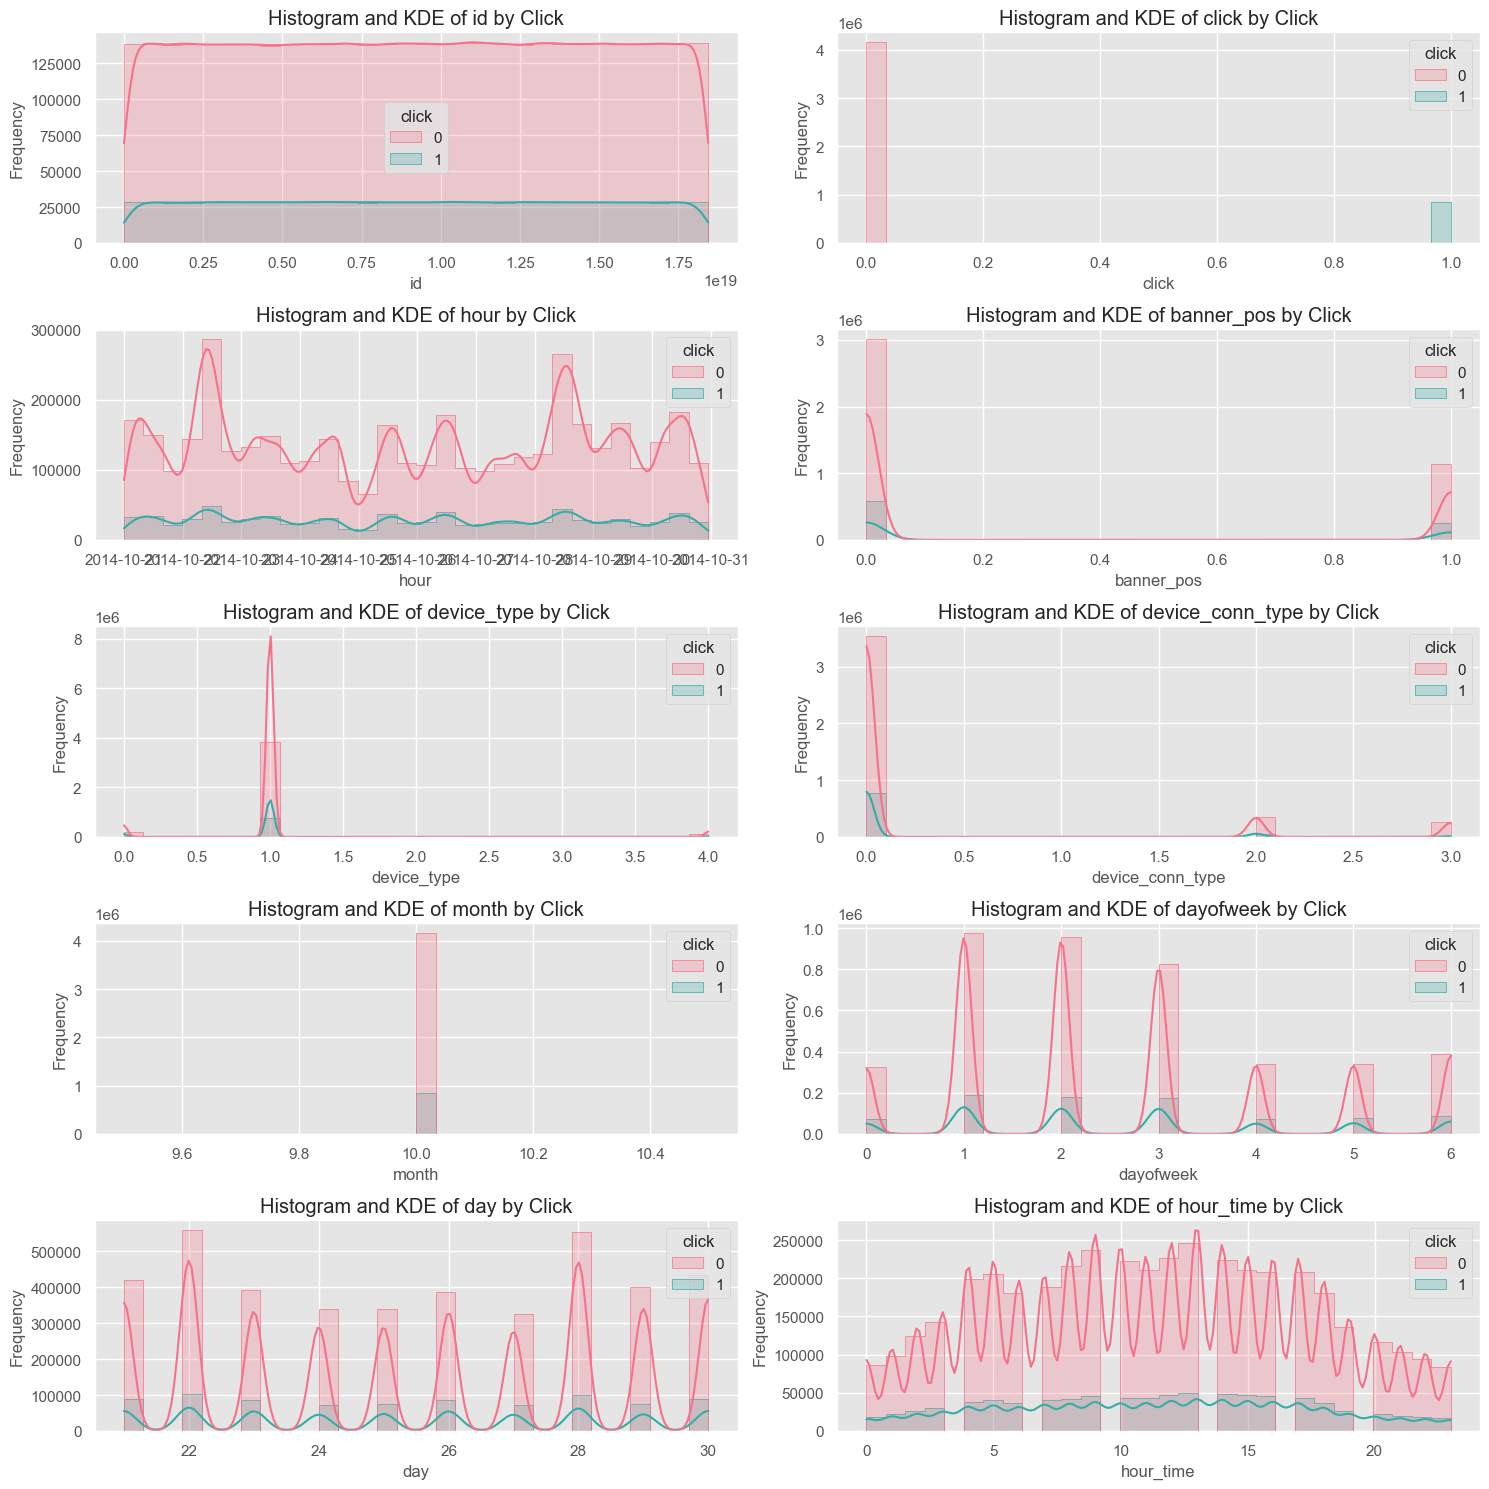

In [ ]:
# Plot histograms and KDEs for numeric columns by 'click' in a tight layout
n = 2  # Number of columns in the subplot grid
plt.figure(figsize=[15, 3 * math.ceil(len(numerical) / n)])  # Adjust figure size

for i, col in enumerate(numerical):
    plt.subplot(math.ceil(len(numerical) / n), n, i + 1)
    sns.histplot(data=train, x=col, hue='click', kde=True, bins=30, palette='husl', element='step')
    plt.title(f"Histogram and KDE of {col} by Click")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()  # Ensure no overlapping of subplots
plt.show()

#### Observations

3. banner_pos
Almost all impressions are at position 0 or 1 (e.g. top vs. side), with virtually no other positions.

Clicks (teal bars) are relatively more concentrated in position 0 than in position 1.

4. device_type
The vast majority of traffic is from a single device category (type 1), with small tails at types 0 and 4.

The click KDE is proportionally higher at type 1 than at the rarer types.

5. device_conn_type
Most impressions on connection type 0, with smaller clusters at 2 and 3.

Click density is relatively higher on type 2 connections.

6. month
It’s essentially constant (all in October), so there’s no information.

7. dayofweek
You have clear peaks on weekdays (e.g. Monday=0, Wednesday=2, Friday=4).

Click density shows that some weekdays (e.g. mid-week) have relatively more clicks per impression.

8. day
Daily totals bounce up and down (perhaps weekends vs. weekdays), and click-KDE shifts accordingly.

9. hour_time
Similar to hour, but as an integer 0–23: clear peak click hours around 10–12 and 18–20.

Small cardinality categorical features often represent meaningful groupings (e.g., device type, banner position). Visualizing their click rates can reveal patterns or trends, such as which categories are more likely to result in clicks.

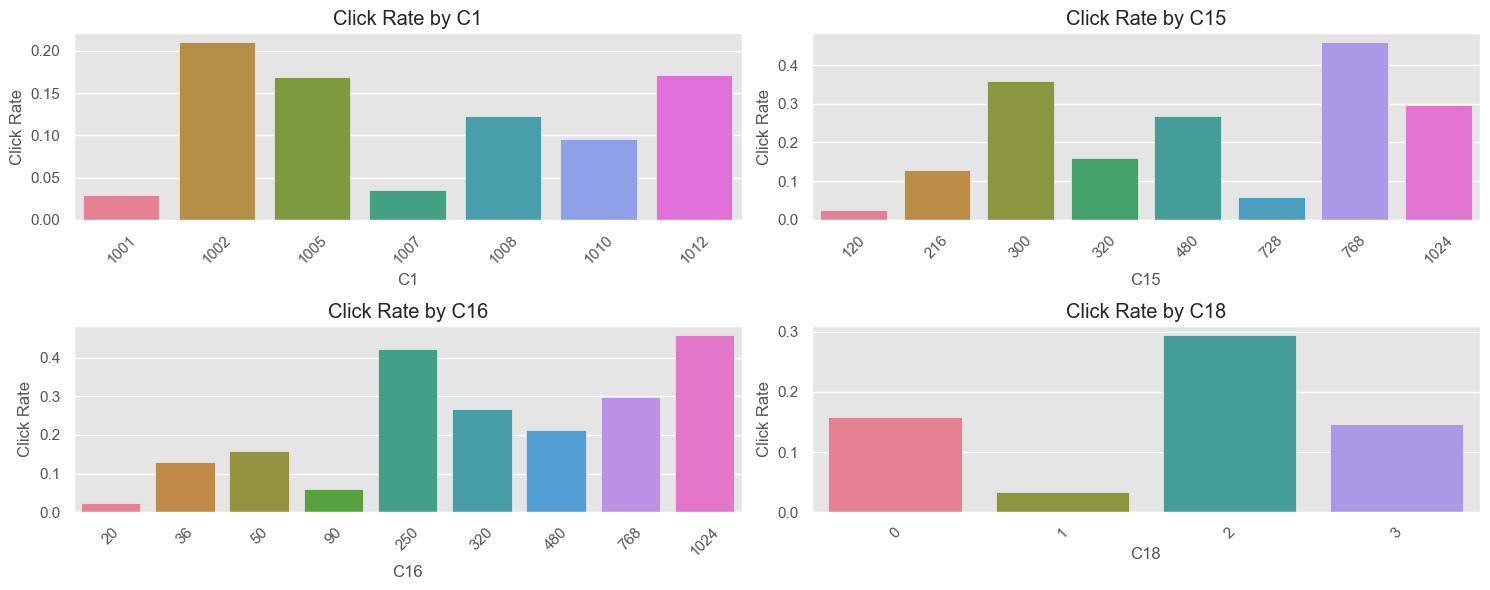

In [ ]:
# Plot bar plots for categorical columns with small cardinality in a tight layout
small_cardinality_cols = [col for col in categorical if train[col].nunique() <= 10]  # Filter columns with small cardinality
n = 2  # Number of columns in the subplot grid
plt.figure(figsize=[15, 3 * math.ceil(len(small_cardinality_cols) / n)])  # Adjust figure size

for i, col in enumerate(small_cardinality_cols):
    plt.subplot(math.ceil(len(small_cardinality_cols) / n), n, i + 1)
    click_rate = train.groupby(col)['click'].mean().reset_index()  # Calculate click rate
    sns.barplot(data=click_rate, x=col, y='click', palette='husl')
    plt.title(f"Click Rate by {col}")
    plt.xlabel(col)
    plt.ylabel("Click Rate")
    plt.xticks(rotation=45)

plt.tight_layout()  # Ensure no overlapping of subplots
plt.show()

#### Observations
C15 (8 levels)
Monotonic trend: CTR climbs steadily from small values (e.g. 120 → ~2%) to large (768 → ~45%), then dips slightly at 1024 (~30%).

C16 (8 levels)
Similar pattern: small levels (20,36,50) have low CTR (<15%), mid levels (250,320) jump to ~40%, and highest (1024) reaches ~45%.

In [ ]:
# Variance Threshold - Drop numeric features with near-zero variance—they carry almost no information.
from sklearn.feature_selection import VarianceThreshold
numerical_filtered = [col for col in numerical if col != 'hour']
train_threshold = train[numerical_filtered]

# Define a variance threshold (e.g., 0.01)
threshold = 0.01

# Initialize the VarianceThreshold object
selector = VarianceThreshold(threshold=threshold)

# Fit the selector to the numerical features
selector.fit(train_threshold)

# Identify features with variance below the threshold
low_variance_features = train_threshold.columns[~selector.get_support()]

print("Features with near-zero variance:", low_variance_features.tolist())

Features with near-zero variance: ['month']


χ² test on each categorical feature versus your binary click label is essentially testing the null hypothesis that “click” is independent of that feature. The larger the χ² statistic, the stronger the evidence that the feature and click label are associated.

In [ ]:
# Univariate Statistical Tests – χ² test for categorical vs. label
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Apply Chi-Square test for categorical features
categorical_features = [col for col in categorical if col != 'click']  # Exclude the target column
X_categorical = train[categorical_features]
y = train['click']  # Target variable

# Use LabelEncoder to encode categorical variables
label_encoders = {}
for col in X_categorical.columns:
    le = LabelEncoder()
    X_categorical[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

# Perform Chi-Square test
chi2_selector = SelectKBest(score_func=chi2, k='all')  # Use 'all' to score all features
chi2_selector.fit(X_categorical, y)

# Display Chi-Square scores
chi2_scores = pd.DataFrame({
    'Feature': X_categorical.columns,
    'Chi2 Score': chi2_selector.scores_
}).sort_values(by='Chi2 Score', ascending=False)

print(chi2_scores)

          Feature  Chi2 Score
10            C14 10843281.76
7       device_id  9430892.85
4          app_id  8169331.82
2     site_domain  2981487.54
13            C17  1550976.31
16            C20  1511013.74
17            C21   390771.75
8       device_ip   224232.26
6    app_category   195463.05
1         site_id   171010.99
9    device_model    25465.84
12            C16     9043.74
15            C19     5449.06
14            C18     2927.63
11            C15     1370.21
0              C1      926.80
5      app_domain      904.35
3   site_category      287.30


#### Observations
Prioritize high‐χ² features

C14, C17, C20, C21, C16: These “C” variables form a core block of strong predictors. You already know C14/C17 are redundant—pick one (e.g. C14) or combine them intelligently.

Guard against ID‐leakage

used to evaluate the relationship between numerical features and the binary target variable (click). It tests whether the means of the numerical feature values differ significantly between the two classes (clicked vs. not clicked).

In [ ]:
# ANOVA F-test for numeric vs. label — pick top-k scoring features.
from sklearn.feature_selection import f_classif

# Apply ANOVA F-test for numerical features
numerical_features = [col for col in numerical if col != 'click' and col != 'hour']  # Exclude the target column
X_numerical = train[numerical_features]

# Perform ANOVA F-test
f_scores, p_values = f_classif(X_numerical, y)

# Display F-scores and p-values
anova_scores = pd.DataFrame({
    'Feature': X_numerical.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values(by='F-Score', ascending=False)

print(anova_scores)

            Feature  F-Score  P-Value
3  device_conn_type 35248.54     0.00
2       device_type  7230.08     0.00
1        banner_pos  2909.45     0.00
5         dayofweek  1312.20     0.00
6               day   289.52     0.00
7         hour_time    22.10     0.00
0                id     0.00     0.95
4             month      NaN      NaN


#### Observations

device_conn_type (F≈35 248, p≈0.00)
The mean connection type is extremely different for clicked vs. non-clicked examples—this is by far your strongest numeric separator.

device_type (F≈7 230, p≈0.00)
Likewise, the device category shows a very large mean shift across click/no-click.

banner_pos (F≈2 909, p≈0.00)
The ad’s position has a highly significant effect on click rates—later positions see different average click behavior.

dayofweek (F≈1 312, p≈0.00) and day (F≈290, p≈0.00)
Both the weekday and calendar-day show statistically significant mean differences for clicked ads—your temporal features matter.

hour_time (F≈22, p≈0.00)
Time-of-day also differs between click classes, albeit less strongly than the others.


## Bivariate + Multicollinearity Analysis

calculates the pairwise linear correlation coefficients between numerical features in the dataset.Identifies highly correlated features, which may be redundant.

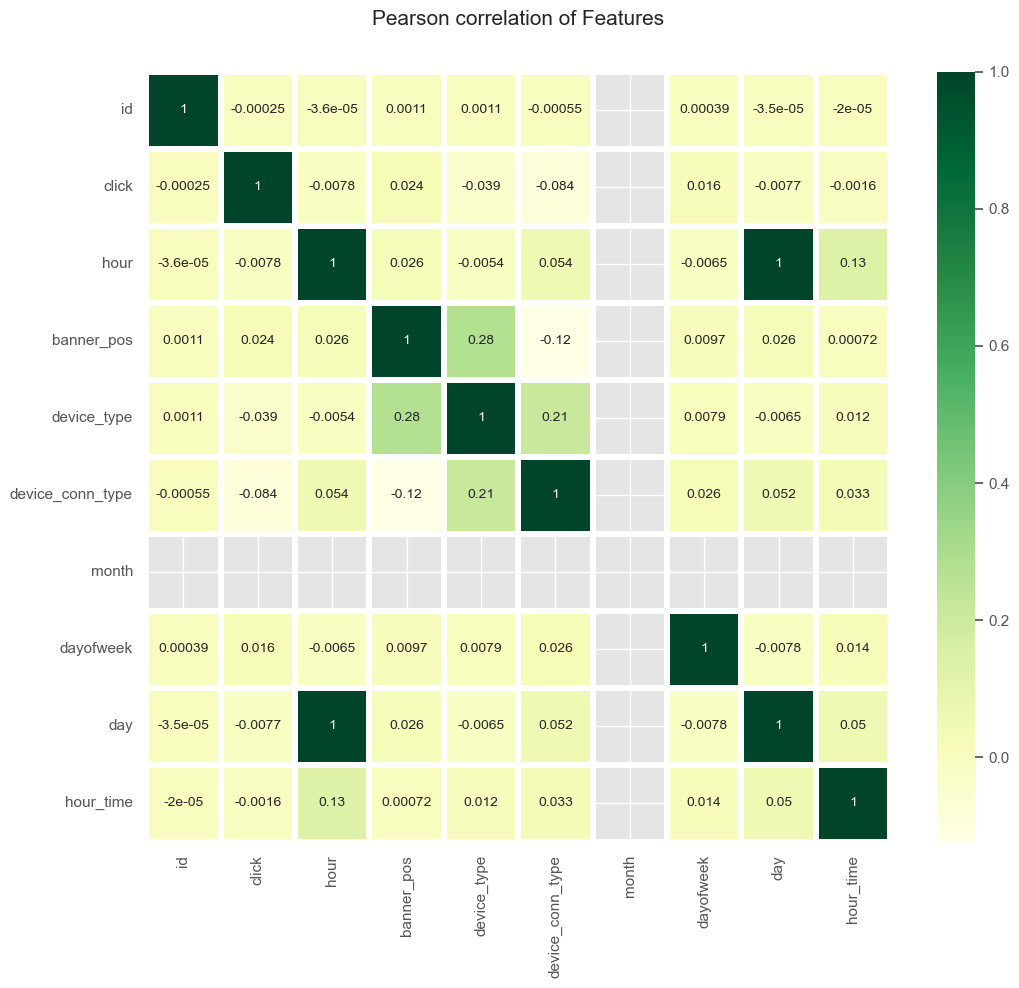

In [ ]:
# Pearson correlation table to find the relationship with output with all numerical input features. 

# Use the columns listed in the 'numerical' list
numeric_columns = train[numerical]

# Compute the Pearson correlation matrix
corr = numeric_columns.corr()

# Plot the heatmap
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, ax=ax, annot=True, linewidths=3, cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)
plt.show()

#### Observations
Moderate feature–feature relationships

banner_pos ↔ device_type: r≈0.28

device_type ↔ device_conn_type: r≈0.21
These aren’t extreme, but you could either drop one of each pair in a purely linear model or let a tree/regularized model sort out the slight redundancy.

Linear models will struggle to capture click behavior off raw features alone—consider adding feature crosses (e.g. site_category×hour_bucket) or polynomial/spline transforms.

Tree-based or kernel methods (e.g. Random Forest, XGBoost, SVM) can pick up non-linear interactions without manual crossing.

Regularization (L1/L2) or dimensionality-reduction (PCA on device_/banner_ block) can help if you want to collapse mildly correlated groups.

In [ ]:
# id column have a unique columns so keeping that doesn't provide any significance,hence dropping.

train.drop(['id', 'month'], axis = 1, inplace = True) 
train.columns

measures the dependency between two variables, quantifying how much knowing one variable reduces uncertainty about the other. 

            Feature  Mutual Information
2       device_type                0.23
5         dayofweek                0.13
6               day                0.09
4             month                0.08
1        banner_pos                0.06
7         hour_time                0.04
3  device_conn_type                0.03
0                id                0.00


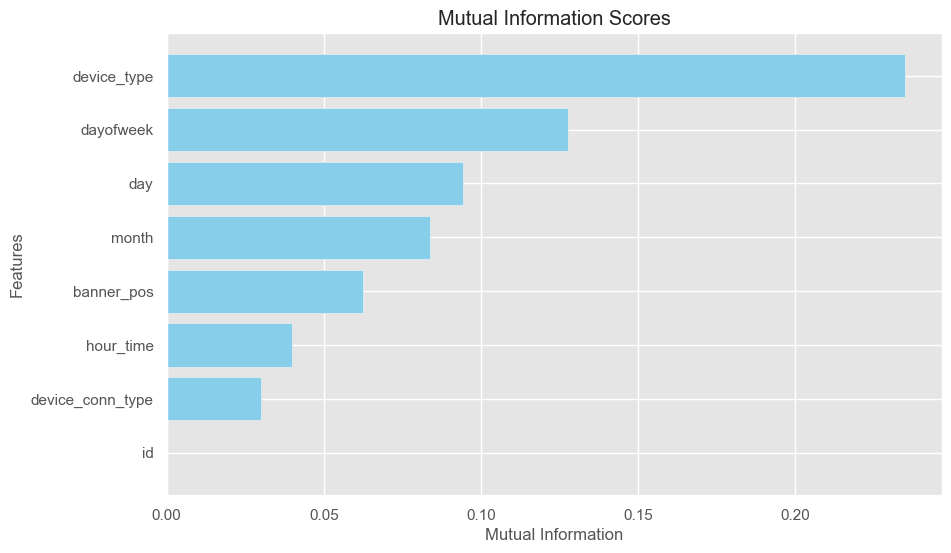

In [ ]:
# compute each numerical feature's mutual information with the click label
from sklearn.feature_selection import mutual_info_classif

# Prepare the data
# Assuming 'numerical' contains the list of numerical columns
X = train[numerical].drop(columns=['click','hour'], errors='ignore')  # Exclude the target column if present
y = train['click']  # Target variable

# Compute mutual information
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the results
print(mi_df)

# Visualize the mutual information scores
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Mutual Information Scores')
plt.gca().invert_yaxis() 
plt.show()

#### Observations
device_type (~0.23)
By far the most informative single feature: knowing the device type reduces uncertainty about clicks more than any other numeric field.

dayofweek (~0.13)
Weekday vs. weekend or specific weekdays carry a fair amount of signal—click behavior varies through the week.

day (~0.095) and month (~0.085)
There’s a mild seasonal or monthly trend—perhaps campaigns or budgets shift over calendar time.

banner_pos (~0.065)
The ad’s position on the page has some non-linear effect on click likelihood.

hour_time (~0.04) and device_conn_type (~0.03)
Time-of-day and connection type add a little extra information, but relatively little on their own.

In [ ]:
# VIF for numeric features
X = train[numerical].dropna()  
if 'hour' in X.columns:
    X = X.drop(columns=['hour'])  

# print(X.dtypes)  # Check data types of columns

# Calculate VIF for numeric features
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data.sort_values(by="VIF", ascending=False))

            Feature  VIF
0                id 1.00
4  device_conn_type 0.96
1             click 0.95
2        banner_pos 0.91
6         dayofweek 0.64
8         hour_time 0.53
3       device_type 0.50
7               day 0.05
5             month 0.00


#### Observations

VIF ≈ 1 (id at 1.00, device_conn_type 0.96, click 0.95, banner_pos 0.91):
These features have essentially no linear dependence on the rest. Their coefficient variances aren’t being inflated by collinearity.

VIF < 1 (dayofweek 0.64, hour_time 0.53, device_type 0.50):
Values below 1 are a bit non-standard (VIF is really defined ≥1), but in practice it simply means these features have very low R^2
  when regressed on the others—i.e. they’re nearly orthogonal.

Near-zero VIF (day 0.05, month 0.00):
A VIF of zero usually indicates the feature is either (a) perfectly constant in your sample (so no variance to explain), or (b) perfectly predicted by the remaining predictors (so R^2≈1). In your case, since you saw month taking only one or very few values, it’s almost surely acting like a constant—so it carries no independent information and should be dropped.

          Feature  NMI
7       device_id 0.04
8       device_ip 0.03
12            C16 0.02
1         site_id 0.02
14            C18 0.02
2     site_domain 0.02
4          app_id 0.02
11            C15 0.02
13            C17 0.01
5      app_domain 0.01
17            C21 0.01
10            C14 0.01
6    app_category 0.01
15            C19 0.01
3   site_category 0.01
16            C20 0.01
9    device_model 0.01
0              C1 0.00


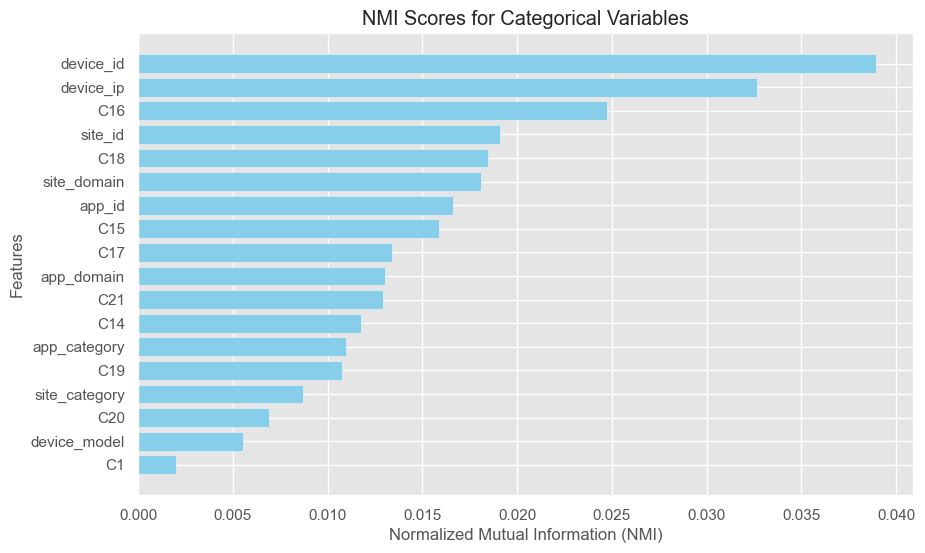

In [ ]:
# Use Normalized Mutual Information (NMI)
from sklearn.metrics import normalized_mutual_info_score

# Prepare the data
categorical_columns = categorical 
target = 'click'  

# Compute NMI for each categorical variable
nmi_scores = {}
for col in categorical_columns:
    nmi = normalized_mutual_info_score(train[col], train[target])
    nmi_scores[col] = nmi

# Create a DataFrame for better visualization
nmi_df = pd.DataFrame(list(nmi_scores.items()), columns=['Feature', 'NMI'])
nmi_df = nmi_df.sort_values(by='NMI', ascending=False)

# Display the results
print(nmi_df)

# Visualize the NMI scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(nmi_df['Feature'], nmi_df['NMI'], color='skyblue')
plt.xlabel('Normalized Mutual Information (NMI)')
plt.ylabel('Features')
plt.title('NMI Scores for Categorical Variables')
plt.gca().invert_yaxis()
plt.show()

#### Observations
Higher NMI ⇒ more predictive power

device_id (≈0.038) and device_ip (≈0.034) top the list, meaning that knowing exactly which device or IP is clicking reduces your uncertainty about “click” the most.

Mid-range features like C16 (≈0.025), site_id, site_domain, app_id, C18 (≈0.020–0.022) carry a moderate signal.

Lower‐down variables (e.g. C1, device_model, C20, site_category) have very low NMI (<0.01), suggesting they’re nearly independent of the click behavior.

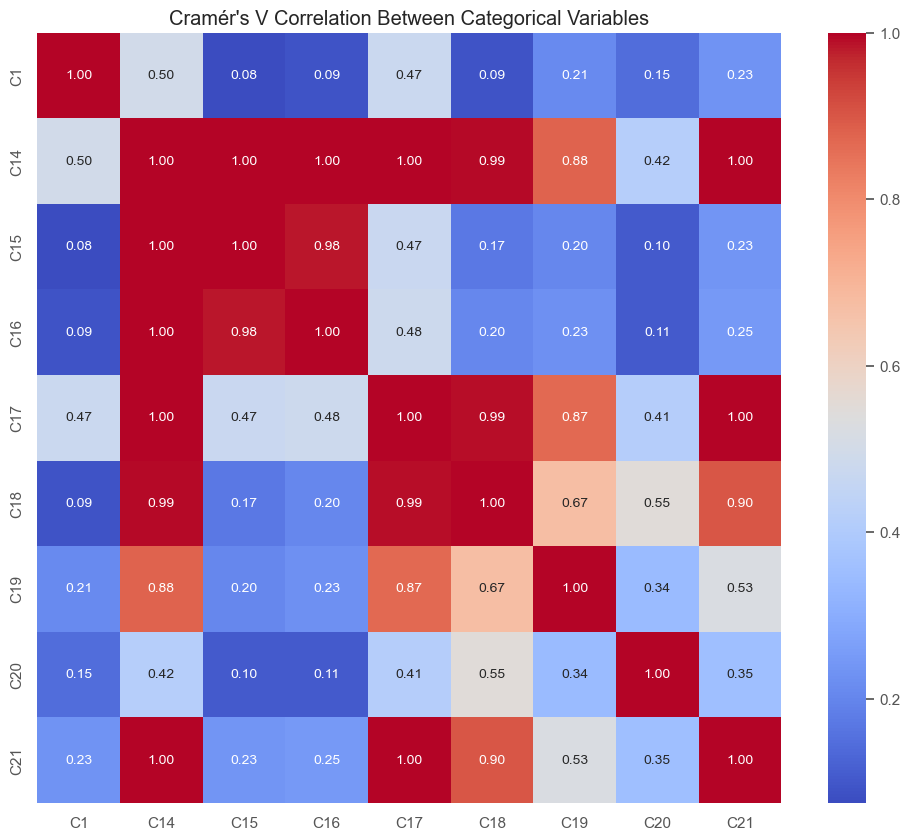

In [ ]:
# Cramers V to measure correlation between categorical vars
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((k_corr - 1), (r_corr - 1)))

# Encode categorical variables
label_encoders = {}
selected_columns = ['C1','C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
for col in selected_columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le

# Compute Cramér's V for all pairs of categorical variables
correlation_matrix = pd.DataFrame(index=selected_columns, columns=selected_columns)
for col1 in selected_columns:
    for col2 in selected_columns:
        correlation_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

# Convert to float for heatmap
correlation_matrix = correlation_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramér's V Correlation Between Categorical Variables")
plt.show()

#### Observations
That giant clique of C14, C15, C16, C17, C18, and C21 all carrying V near 1.0 means they’re essentially duplicate or co-assigned categories—they never vary independently in your data.

C19 and C20 share some information with that core group (moderate V) but also bring a bit of unique variation.

C1 is the most independent of the bunch (lowest average V)—it may add fresh signal.

### Conclusion/ Decisions

Same feedback as proposal for feature engineering: Since your dataset is fairly simple, try more things here. Ex: Combinations, counts, binning, replacing low values to address sparsity, etc. Look at kaggle notebooks for inspiration.

You can also explore more feature selection methods in addition to feature engineering (ex: RFE). These experiments can be run on smaller subsets of training data, but detail how you took the sample. You can also use something like SHAP to assess feature importance for tree-based models.


#### Numerical
Engineer Interactions & Bins

- Because no single feature is strongly predictive on its own, create crosses like device_type × dayofweek or bin hour_time into “morning/afternoon/night” and test the MI of those new features.

- You can also discretize (banner_pos into edge-vs-middle buckets) and re-compute MI to see if the binned version carries more signal.

Transform Skewed Distributions

- For any numeric whose histogram is heavily skewed (you saw that in your univariate EDA), apply a log or power transform—this can often increase MI by making relationships more linear for downstream models.

Scale Appropriately

- Use a RobustScaler or QuantileTransformer if there are still heavy tails or outliers in your cleaned data; otherwise a Standard or MinMax scaler will work fine for most algorithms.

- Action: definitely include hour_time (with cyclical transforms or bins) since its KDE shows a distinct click‐pattern shape. consider cyclical encoding (sine/cosine) to capture its periodic nature.

You might also bin into “morning/afternoon/evening/night” buckets if you want a simpler signal.

- Treat banner_pos as a binary or low-cardinality categorical feature.

- One-hot encode or map “is_top_position” to let your model easily separate those two.

- One-hot or ordinal-encode device_type, but be mindful that the rare types may add noise—consider grouping them if sample counts are tiny.
- one-hot or cyclical encode dayofweek—it undeniably carries signal.
- device_type ↔ device_conn_type: r≈0.21
    These aren’t extreme, but you could either drop one of each pair in a purely linear model or let a tree/regularized model sort out the slight redundancy.

#### Categorical

- C15 Bin into low/medium/high buckets based on breakpoints (e.g. <300, 300–700, >700).
- C16 same as for C15—a numeric or binned variable will capture this strong size-driven effect more compactly than one-hot.

##### Chi Squared

- site_category, app_domain, C1, C15: very low χ² scores. You can safely remove these from your baseline if you need to trim dimensionality—or test removing them to see if performance holds.

- Re-evaluate numeric vs. categorical treatment

- C15 has low χ² yet in your CTR bar‐plots shows a monotonic trend. That suggests treating C15 as a numeric (or ordinal) feature may unlock its true predictive power better than categorical χ².

##### ANOVA

- For those high-F features, consider whether any need non-linear transforms (e.g. binning “banner_pos”) or more granular encoding (e.g. cyclical encoding for “dayofweek/hour_time”).

##### NMI

Explore interactions

- Even moderately informative fields can become powerful when crossed with time features or each other.

- e.g. site_category × hour_bucket, device_conn_type × app_domain—generate a handful of these and re-compute NMI or feature importance to pick the winners.

Drop or re-engineer “leaky” high-cardinality IDs

- Remove device_id and device_ip as raw features—they will overfit.

- If you want to capture user-level behavior, aggregate them into statistics:

- e.g. “click rate for this device_id in the past N clicks,” or total impressions per IP bucket.

- Always compute those aggregates in a strictly out-of-sample or cross-validated way to avoid leakage.

Target-encode moderately informative fields

- For site_id, site_domain, app_id, app_domain, C16, C18, C21, C14, C15, C17 (NMI ≈0.012–0.022):

- Use smoothed target encoding (with prior blending) or frequency encoding rather than one-hot—this keeps dimensionality manageable and leverages their genuine signal.

- Wrap your encoding inside your cross-validation folds to prevent target leakage.

One-hot or grouped encoding for low-NMI, low-cardinality fields

- For features like site_category, device_model (few dozen levels) and C20, C1 (very weak signal):

- Either one-hot encode if you think small category buckets still matter, Or group rare levels (<1% frequency) into an “Other” bucket and then one-hot.

- If NMI remains near zero, consider dropping them entirely.

Watch out for data leakage

Ultra‐high cardinality fields like device_id and device_ip often “memorize” the training set (each ID may appear only once), so their high NMI can be a red flag for overfitting or label leakage rather than genuine, reusable signal.

##### Cramers

Collapse or drop near-duplicates

Pick one representative from that high-V cluster (e.g. C14), and drop the rest.

Alternatively, combine them into a single feature (e.g. concatenate their category codes or map them into a common “super-category”).

Re-evaluate moderate correlates

For C19 and C20, check their individual NMI with the click label (you already did that).

If one outperforms the other, you might drop the weaker.

Otherwise, keep both but be aware they share some redundancy with your core group.

Retain truly independent variables

C1 showed the lowest association—keep it as a likely source of additional signal.

Re-run your encoding strategy

With fewer, de-duplicated categories, you’ll avoid over-parameterizing your target encoder or hashing trick.

This will also speed up fitting and reduce overfitting risk.

# 5. Model Pipeline (Feature Engineering)

## Building basic models [Feature engineering]
1. We will run multiple models 
      a.Dummy Classifier
      b. Logistic regression [for explainability and finding linear relationship]
      c. Decision tree classifier [for explainability and also for non-linear relation]
      d. Random forest classifier [for accuracy and improving the model] 
      e. XGBClassifier
      f. KNN
      g. Bagging Classifier

## Train-Validation-Test Split Setup

In [419]:
# Sample 10% of the data
sampled_feat_data = train.sample(frac=0.1, random_state=42)

# Sort the data by the 'hour' column to maintain temporal order
sampled_feat_data = sampled_feat_data.sort_values(by='hour')
sampled_feat_data.drop(['hour'], axis = 1, inplace = True) 
X_feat = sampled_feat_data.drop(['y'], axis=1)
y_feat = sampled_feat_data['y']

y
0   0.83
1   0.17
Name: proportion, dtype: float64




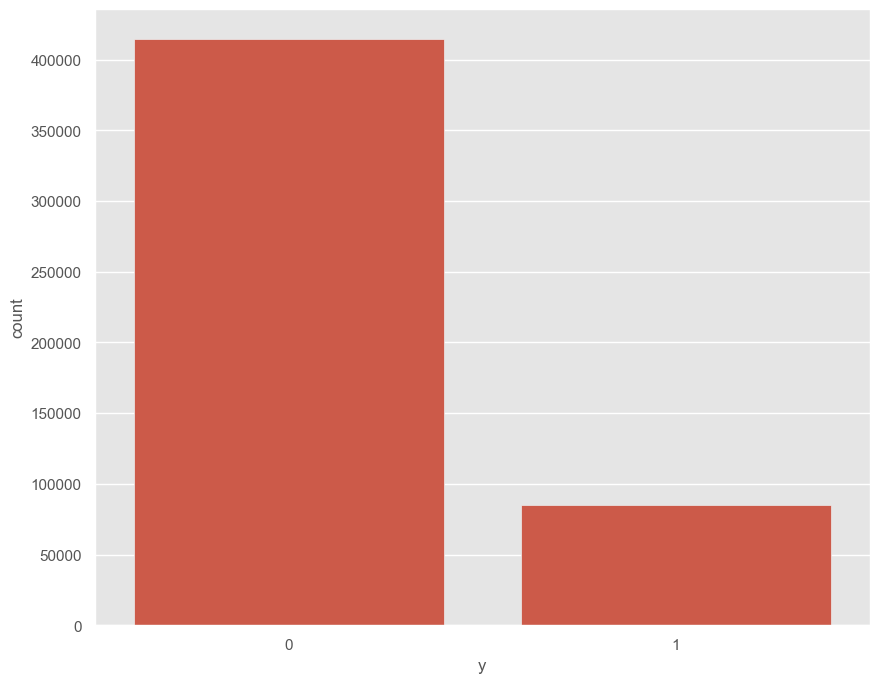

In [420]:
# # After taking the sample of data, still the ratio of output remains same.

print(sampled_feat_data.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

# 5b. Feature Engineering

## Feature Encoding

### Feature Binning & Discretization

In [ ]:
# C15 Bin into low/medium/high buckets based on breakpoints (e.g. <300, 300–700, >700).

from sklearn.tree import DecisionTreeRegressor

# Select the column to bin (e.g., C15) and the target variable (e.g., click)
X_feat_bins = X_feat[['C15']]

# Fit a decision tree to find optimal splits
tree = DecisionTreeRegressor(max_depth=2, random_state=42)  # Adjust max_depth as needed
tree.fit(X_feat_bins, y_feat)

# Extract the split points
binning_points = sorted(tree.tree_.threshold[tree.tree_.threshold != -2])
print("Natural binning points:", binning_points)

# Use the binning points to create bins
bin_labels = ['low', 'medium', 'high', 'very high']  # Updated bin labels

# Ensure the number of bins matches the labels
X_feat['C15_binned'] = pd.cut(X_feat['C15'], bins=[-np.inf, 258.0, 310.0, 604.0, np.inf], labels=bin_labels)
print(X_feat[['C15', 'C15_binned']].head())


Natural binning points: [258.0, 310.0, 604.0]
      C15 C15_binned
4094  320       high
771   320       high
4164  320       high
5698  320       high
9551  320       high


In [ ]:
# C16 Bin into low/medium/high buckets based on breakpoints 

# Select the column to bin (e.g., C16) and the target variable (e.g., click)
X_feat_bins = X_feat[['C16']]

# Fit a decision tree to find optimal splits
tree = DecisionTreeRegressor(max_depth=2, random_state=42)  # Adjust max_depth as needed
tree.fit(X_feat_bins, y_feat)

# Extract the split points
binning_points = sorted(tree.tree_.threshold[tree.tree_.threshold != -2])
print("Natural binning points:", binning_points)

# Use the binning points to create bins
bin_labels = ['low', 'medium', 'high', 'very high']  # Updated bin labels

# Ensure the number of bins matches the labels
X_feat['C16_binned'] = pd.cut(X_feat['C16'], bins=[-np.inf, 70.0, 170.0, 400.0, np.inf], labels=bin_labels)
print(X_feat[['C16', 'C16_binned']].head())

Natural binning points: [70.0, 170.0, 400.0]
      C16 C16_binned
4094   50        low
771    50        low
4164   50        low
5698   50        low
9551   50        low


In [423]:
# Drop the original C15, C16 columns after binning
X_feat.drop(columns=['C15'], inplace=True)
X_feat.drop(columns=['C16'], inplace=True)
X_feat.head()

id    C1  banner_pos  ... hour_time C15_binned C16_binned
4094  14725329914147110295  1005        0.00  ...      0.00       high        low
771     108846178740989759  1005        1.00  ...      0.00       high        low
4164  14806380920363419661  1005        0.00  ...      0.00       high        low
5698  16522376812513715237  1005        1.00  ...      0.00       high        low
9551   4144227210439191390  1005        0.00  ...      0.00       high        low

[5 rows x 26 columns]

In [424]:
# For those high-F features, consider whether any need non-linear transforms (e.g. binning “banner_pos”). Treat banner_pos as a binary or low-cardinality categorical feature.
# Binning banner_pos into two categories: 'top' and 'other'
X_feat['banner_pos_binned'] = X_feat['banner_pos'].apply(lambda x: 'top' if x == 0 else 'other')

# Verify the transformation
print(X_feat[['banner_pos', 'banner_pos_binned']].head())

      banner_pos banner_pos_binned
4094        0.00               top
771         1.00             other
4164        0.00               top
5698        1.00             other
9551        0.00               top


In [425]:
# Drop the original banner_pos column
X_feat.drop(columns=['banner_pos'], inplace=True)
X_feat.head()

id    C1  ... C16_binned banner_pos_binned
4094  14725329914147110295  1005  ...        low               top
771     108846178740989759  1005  ...        low             other
4164  14806380920363419661  1005  ...        low               top
5698  16522376812513715237  1005  ...        low             other
9551   4144227210439191390  1005  ...        low               top

[5 rows x 26 columns]

In [426]:
# Check the minimum and maximum values for hour_time
min_hour = train['hour_time'].min()
max_hour = train['hour_time'].max()

print(f"Minimum value for hour_time: {min_hour}")
print(f"Maximum value for hour_time: {max_hour}")

Minimum value for hour_time: 0.0
Maximum value for hour_time: 23.0


In [427]:
# hour_time bin into “morning/afternoon/evening/night” buckets
# Binning hour_time into "morning/afternoon/evening/night"
def bin_hour(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

X_feat['hour_binned'] = X_feat['hour_time'].apply(bin_hour)

# Verify the transformation
print(X_feat[['hour_time', 'hour_binned']].head())

      hour_time hour_binned
4094       0.00       night
771        0.00       night
4164       0.00       night
5698       0.00       night
9551       0.00       night


### Rare Category Grouping TODO if time permits

### Categorical Encoding

In [428]:
# Cyclical encoding for 'dayofweek'
X_feat['dayofweek_sin'] = np.sin(2 * np.pi * X_feat['dayofweek'] / 7)
X_feat['dayofweek_cos'] = np.cos(2 * np.pi * X_feat['dayofweek'] / 7)

# Drop the original 'dayofweek' column if no longer needed
X_feat.drop('dayofweek', axis=1, inplace=True)

# Verify the result
print(X_feat[['dayofweek_sin', 'dayofweek_cos']].head())

      dayofweek_sin  dayofweek_cos
4094           0.78           0.62
771            0.78           0.62
4164           0.78           0.62
5698           0.78           0.62
9551           0.78           0.62


In [429]:
# Segregating numerical and categorical variables.

numerical = []
categorical = []

# List of anonymized categorical variables
anonymized_categorical = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20','C21']

for col in X_feat.columns:
    if X_feat[col].dtype == "object" or col in anonymized_categorical:
        categorical.append(col)
    else:
        numerical.append(col)

print("numerical columns = ", numerical)
print("\ncategorical columns = ", categorical)

numerical columns =  ['id', 'device_type', 'device_conn_type', 'month', 'day', 'hour_time', 'C15_binned', 'C16_binned', 'dayofweek_sin', 'dayofweek_cos']

categorical columns =  ['C1', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'C14', 'C17', 'C18', 'C19', 'C20', 'C21', 'banner_pos_binned', 'hour_binned']


In [ ]:
import category_encoders as ce

fields_to_encode = ['site_id', 'site_domain', 'site_category', 'device_model', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'C18', 'C19', 'C21', 'C14', 'C17', 'banner_pos_binned', 'hour_binned','C16_binned','C15_binned']

fields_to_one_hot_encode = ['C1']

# Initialize the target encoder with smoothing
# Smoothing parameter controls the weight of the prior (higher value = more smoothing)
target_encoder = ce.TargetEncoder(cols=fields_to_encode, smoothing=5.0)

# Fit the target encoder on the entire dataset and transform the fields
X_feat_encoded = target_encoder.fit_transform(X_feat, y_feat)

# Apply one-hot encoding to the specified fields
X_feat_encoded = pd.get_dummies(X_feat_encoded, columns=fields_to_one_hot_encode, drop_first=True)

# Verify the transformations
print("Target-encoded and one-hot-encoded data:")
print(X_feat_encoded.head())

Target-encoded and one-hot-encoded data:
                        id  site_id  site_domain  ...  C1_1008  C1_1010  C1_1012
4094  14725329914147110295     0.08         0.08  ...    False    False    False
771     108846178740989759     0.19         0.19  ...    False    False    False
4164  14806380920363419661     0.20         0.20  ...    False    False    False
5698  16522376812513715237     0.09         0.09  ...    False    False    False
9551   4144227210439191390     0.08         0.08  ...    False    False    False

[5 rows x 33 columns]


In [431]:
X_feat_encoded.head()

id  site_id  site_domain  ...  C1_1008  C1_1010  C1_1012
4094  14725329914147110295     0.08         0.08  ...    False    False    False
771     108846178740989759     0.19         0.19  ...    False    False    False
4164  14806380920363419661     0.20         0.20  ...    False    False    False
5698  16522376812513715237     0.09         0.09  ...    False    False    False
9551   4144227210439191390     0.08         0.08  ...    False    False    False

[5 rows x 33 columns]

## Feature Aggregation if time permits
Group-by statistics: mean, sum, count, std of clicks per user/site/app  
Rolling aggregates: last-n clicks, time-since–last-click  


Watch out for data leakage

Ultra‐high cardinality fields like device_id and device_ip often “memorize” the training set (each ID may appear only once), so their high NMI can be a red flag for overfitting or label leakage rather than genuine, reusable signal.
Drop or re-engineer “leaky” high-cardinality IDs

- Remove device_id and device_ip as raw features—they will overfit.

- If you want to capture user-level behavior, aggregate them into statistics:

- e.g. “click rate for this device_id in the past N clicks,” or total impressions per IP bucket.

- Always compute those aggregates in a strictly out-of-sample or cross-validated way to avoid leakage.

## Feature Selection

- device_type ↔ device_conn_type: r≈0.21
    These aren’t extreme, but you could either drop one of each pair in a purely linear model or let a tree/regularized model sort out the slight redundancy.

Collapse or drop near-duplicates
- Pick one representative from that high-V cluster (e.g. C14), and drop the rest.
- Alternatively, combine them into a single feature (e.g. concatenate their category codes or map them into a common “super-category”).

Re-evaluate moderate correlates
- For C19 and C20, check their individual NMI with the click label (you already did that).
- If one outperforms the other, you might drop the weaker. Otherwise, keep both but be aware they share some redundancy with your core group.

Retain truly independent variables
- C1 showed the lowest association—keep it as a likely source of additional signal.
- Re-run your encoding strategy
- With fewer, de-duplicated categories, you’ll avoid over-parameterizing your target encoder or hashing trick.
- This will also speed up fitting and reduce overfitting risk.

In [432]:
# Refer to feature Engineering section
# C1 and device_type are highly corelated, since C1 is anomalised column we can drop it.
# C14 and C17 are highly co-related, dropping either is a good idea.

X_feat_encoded.drop(['C14', 'device_type'], axis=1, inplace= True)

## Handling Class Imbalance

In [433]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler
randomsample = RandomOverSampler(random_state=42)
X_feat_resampled, y_feat_resampled = randomsample.fit_resample(X_feat_encoded, y_feat)

Original class distribution: Counter({0: 414933, 1: 85067})
Resampled class distribution: Counter({0: 414933, 1: 414933})


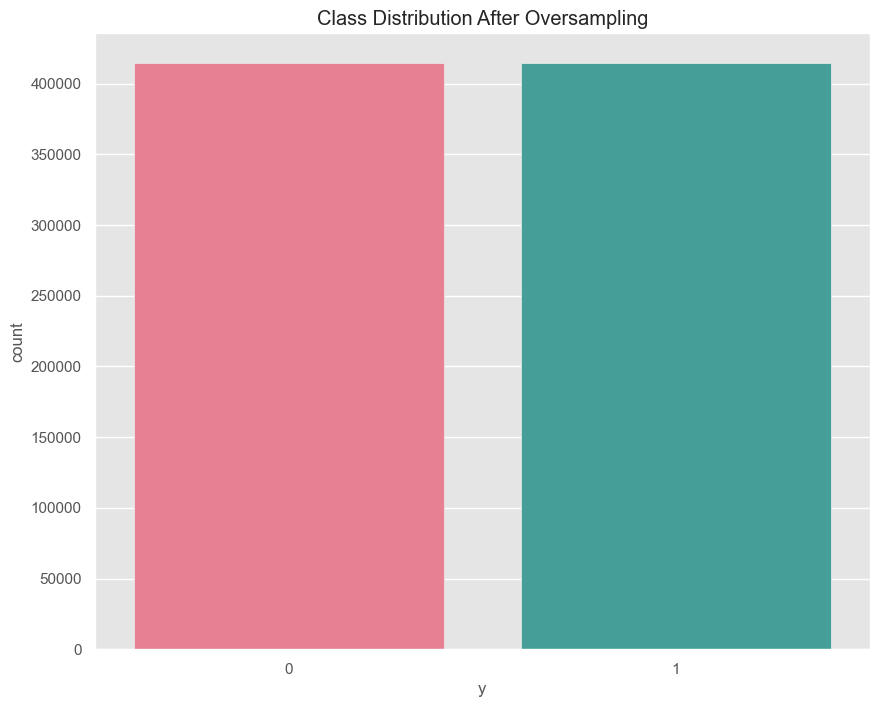

In [434]:
# After oversampling
from collections import Counter

# Check class distribution before and after oversampling
print("Original class distribution:", Counter(y_feat))
print("Resampled class distribution:", Counter(y_feat_resampled))

# Visualize the class distribution after oversampling
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_feat_resampled, palette='husl')
plt.title("Class Distribution After Oversampling")
plt.show()

## Data Reduction & Filtering (during Model Pipeline)

Remove features with near-zero variance. 
Filter out rows outside business thresholds (e.g. impossible banner_pos).
Optionally sample a stratified subset for quick prototyping.

# 5c. Model Pipeline Cont. (Feature Engineering)

## Building basic models [with advanced feature engineering]
 1. in this advanced feature engineering is done apart from removing definate columns click and month.
 2. We will run multiple models 
      a. Dummy Classifier
      b. Logistic regression [for explainability and finding linear relationship]
      c. Decision tree classifier [for explainability and also for non-linear relation]
      d. Random forest classifier [for accuracy and improving the model] 
      e. XGBClassifier
      f. KNN
      g. Bagging Classifier

### Train-Validation-Test Split Setup  

In [435]:
# acknowledges time leak since data is sorted by hour and test data comes after train

# Define the split point (e.g., 80% train, 20% test)
split_point = int(len(X) * 0.8)

# Create train and test sets
X_feat_train, X_feat_test = X_feat_resampled.iloc[:split_point], X_feat_resampled.iloc[split_point:]
y_feat_train, y_feat_test = y_feat_resampled.iloc[:split_point], y_feat_resampled.iloc[split_point:]

# Print the sizes to verify
print(f"Train size: {len(X_feat_train)}, Test size: {len(X_feat_test)}")

Train size: 400000, Test size: 429866


### Dummy Classifier
Dummy classifier helps in baseling the model performace w.r.t dominanat class. 

accuracy test: 0.19503752332122104
confusion mat test:
 [[ 83840      0]
 [346026      0]]
f1 test: 0.0


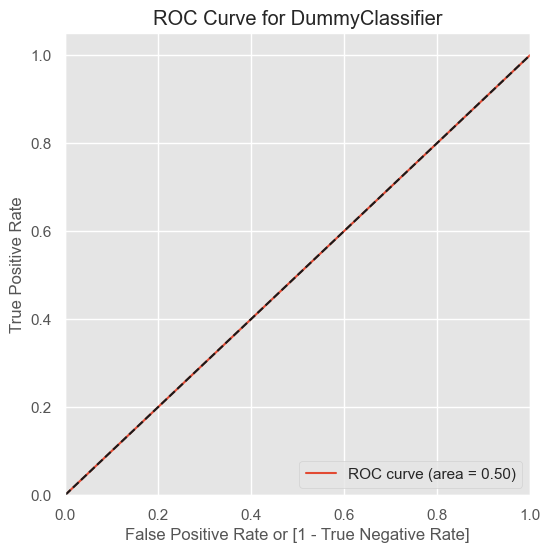

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00

[1 rows x 11 columns]

In [436]:
# Running model against training + collect results
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_feat_train, y_feat_train)
accuracy_test, cnf_matrix_test, f1_test  = model_eval(dummy_clf, X_feat_test, y_feat_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("Dummy classifier", y_feat_train, X_feat_train, y_feat_test, X_feat_test, dummy_clf, 5)
draw_roc(dummy_clf, X_feat_test, y_feat_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

### Logistic regression 

In [437]:
# MinMaxScaler used to scale each feature in the dataset to a specified range (0-1)
# Scale feature values for training data set

# Separate numerical and categorical columns
numerical_cols = X_feat_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_feat_train.select_dtypes(exclude=[np.number]).columns

# Apply MinMaxScaler to numerical columns
scaler = MinMaxScaler()
X_feat_train[numerical_cols] = scaler.fit_transform(X_feat_train[numerical_cols])
X_feat_test[numerical_cols] = scaler.transform(X_feat_test[numerical_cols])

In [438]:
# Train model
LogReg_model = LogisticRegression(penalty='l2', solver = "saga")
LogReg_model.fit(X_feat_train, y_feat_train)

LogisticRegression(solver='saga')

accuracy test: 0.3528541452452625
confusion mat test:
 [[ 82071   1769]
 [276417  69609]]
f1 test: 0.3335329800385238


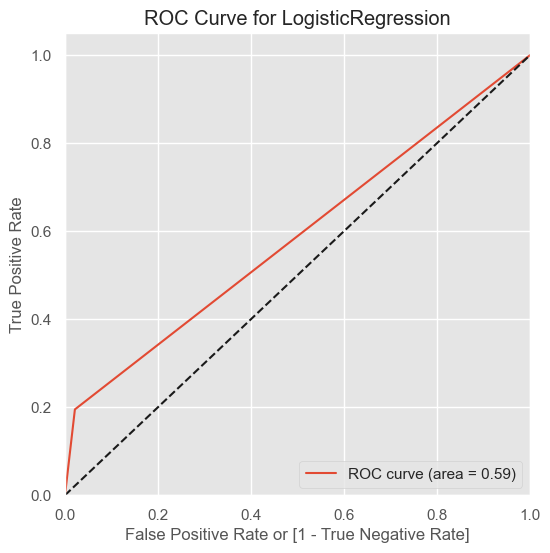

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.84  ...           0.84               0.00

[2 rows x 11 columns]

In [439]:
# Running model against training + collect results
y_pred = LogReg_model.predict(X_feat_test)
accuracy_test, cnf_matrix_feat_test,f1_test = model_eval(LogReg_model, X_feat_test, y_feat_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_feat_test)
print("f1 test:",f1_test)
temp = store_results("logistic regres", y_feat_train, X_feat_train, y_feat_test, X_feat_test, LogReg_model, 5)
draw_roc(LogReg_model, X_feat_test, y_feat_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

###  Decision tree classifier

In [440]:
# decision tree doesn't require feature scaling, will use the raw features directly 
X_feat_train, X_feat_test = X.iloc[:split_point], X.iloc[split_point:]
y_feat_train, y_feat_test = y.iloc[:split_point], y.iloc[split_point:]
X_feat_train.head(2)

id    C1  banner_pos  ...  dayofweek   day  hour_time
4094  14725329914147110295  1005        0.00  ...       1.00 21.00       0.00
771     108846178740989759  1005        1.00  ...       1.00 21.00       0.00

[2 rows x 26 columns]

accuracy test: 0.92122
confusion mat test:
 [[79441  4399]
 [ 3479 12681]]
f1 test: 0.7629963898916968


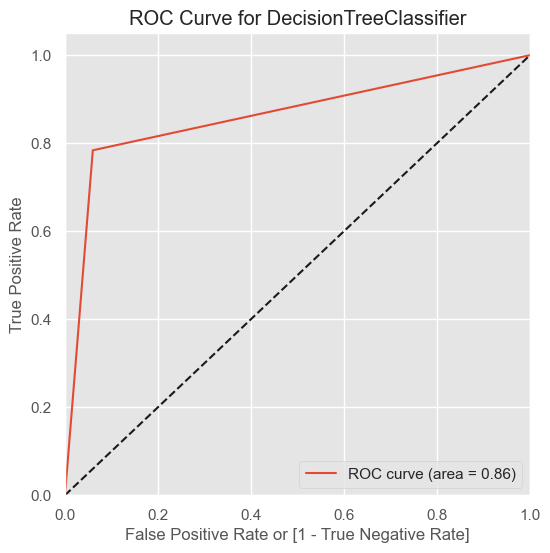

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.84  ...           0.84               0.00
2     Decision Tree            0.99  ...           0.91               0.00

[3 rows x 11 columns]

In [441]:
# Running model against training + collect results
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_feat_train, y_feat_train)
y_preds = dt_basic.predict(X_feat_test)
accuracy_test, cnf_matrix_test, f1_test = model_eval(dt_basic, X_feat_test, y_feat_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("Decision Tree", y_feat_train, X_feat_train, y_feat_test, X_feat_test, dt_basic, 5)
draw_roc(dt_basic, X_feat_test, y_feat_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome


### Random forest classifier


accuracy test: 0.9417
confusion mat test:
 [[82551  1289]
 [ 4541 11619]]
f1 test: 0.7994358056969864


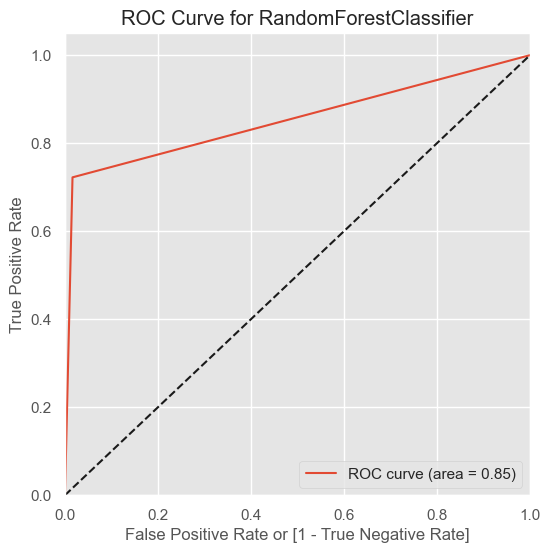

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.84  ...           0.84               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00

[4 rows x 11 columns]

In [442]:
# Running model against training + collect results
model_rf = RandomForestClassifier(random_state=42, n_estimators=100)
model_rf.fit(X_feat_train, y_feat_train)
y_preds = model_rf.predict(X_feat_test)
accuracy_test, cnf_matrix_test, f1_test = model_eval(model_rf, X_feat_test, y_feat_test)
print("accuracy test:",accuracy_test)
print("confusion mat test:\n",cnf_matrix_test)
print("f1 test:",f1_test)
temp = store_results("Random Forest", y_feat_train, X_feat_train, y_feat_test, X_feat_test, model_rf, 5)
draw_roc(model_rf, X_feat_test, y_feat_test)
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome


### KNN


In [445]:
# perform Feature Dimensionality Reduction via PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Standardize the features
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_test_scaled = scaler.transform(X_feat_test)

# Retain 95% of the variance
pca = PCA(n_components=0.95)
X_feat_train_pca = pca.fit_transform(X_feat_train_scaled)
X_feat_test_pca = pca.transform(X_feat_test_scaled)

# Check how many components were selected
print(f"Number of components selected: {pca.n_components_}")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.cumsum())

Number of components selected: 19
Explained Variance Ratio: [0.17438023 0.1056682  0.08691978 0.07816564 0.05473431 0.04672321
 0.04340177 0.04130759 0.03999995 0.03892088 0.03724736 0.03537912
 0.03310931 0.03067113 0.02812731 0.02506269 0.02230805 0.02075705
 0.01792335]
Cumulative Explained Variance: [0.17438023 0.28004843 0.36696821 0.44513384 0.49986815 0.54659136
 0.58999314 0.63130073 0.67130068 0.71022157 0.74746892 0.78284805
 0.81595735 0.84662848 0.87475579 0.89981848 0.92212653 0.94288358
 0.96080693]


In [446]:
# Assuming `pca` is your PCA object and `X_feat_train` is your training dataset
feature_names = X_feat_train.columns  # Get the original feature names
components_df = pd.DataFrame(pca.components_, columns=feature_names)

# Display the components
print("PCA Components (weights for each feature):")
print(components_df)

# Identify the most important features for each component
for i, component in enumerate(components_df.values):
    print(f"\nTop features for Principal Component {i + 1}:")
    top_features = sorted(zip(feature_names, component), key=lambda x: abs(x[1]), reverse=True)[:5]
    for feature, weight in top_features:
        print(f"  {feature}: {weight:.4f}")

PCA Components (weights for each feature):
      id    C1  banner_pos  site_id  ...  month  dayofweek   day  hour_time
0  -0.00 -0.13        0.09     0.31  ...  -0.00       0.03 -0.02      -0.02
1  -0.00 -0.10       -0.01    -0.07  ...   0.00       0.16 -0.06       0.05
2  -0.00  0.55        0.24     0.23  ...  -0.00       0.10  0.03       0.04
3   0.00  0.25        0.34    -0.38  ...  -0.00      -0.05 -0.08      -0.09
4   0.00  0.10       -0.38    -0.01  ...   0.00      -0.09 -0.33      -0.11
5   0.00  0.02        0.12     0.01  ...  -0.00      -0.09  0.24       0.18
6   0.02  0.01        0.04    -0.06  ...   0.00      -0.20 -0.19      -0.38
7   0.05  0.02        0.07     0.04  ...  -0.00       0.20 -0.48      -0.60
8  -1.00 -0.00        0.01     0.01  ...  -0.00      -0.03 -0.04      -0.04
9  -0.04 -0.06       -0.11    -0.04  ...   0.00       0.73  0.18      -0.13
10  0.02 -0.07       -0.15     0.11  ...   0.00      -0.42  0.17      -0.32
11  0.00 -0.00       -0.06     0.00  ...  -0.

In [447]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    algorithm='brute',
    metric='minkowski',  # Or 'manhattan'
    p=2  # Euclidean distance
)

# Train the KNN model on the imbalanced dataset
knn_model.fit(X_feat_train_pca, y_feat_train)

KNeighborsClassifier(algorithm='brute', weights='distance')

Accuracy on test data: 0.93081
Confusion Matrix on test data:
 [[81453  2387]
 [ 4532 11628]]
f1 test: 0.7707042253521126


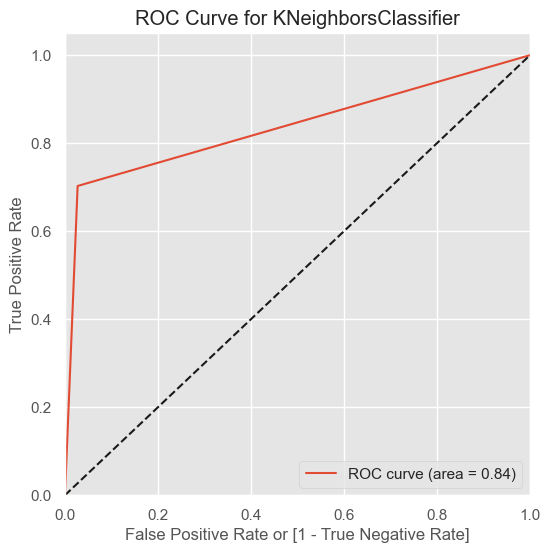

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.84  ...           0.84               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00
4               KNN            0.99  ...           0.92               0.00

[5 rows x 11 columns]

In [448]:
# Running model against training + collect results
accuracy_test, cnf_matrix_test, f1_test = model_eval(knn_model, X_feat_test_pca, y_feat_test)
print("Accuracy on test data:", accuracy_test)
print("Confusion Matrix on test data:\n", cnf_matrix_test)
print("f1 test:",f1_test)

# # Convert PCA-transformed arrays back to DataFrames
X_feat_train_pca_df = pd.DataFrame(X_feat_train_pca, columns=[f"PC{i+1}" for i in range(X_feat_train_pca.shape[1])])
X_feat_test_pca_df = pd.DataFrame(X_feat_test_pca, columns=[f"PC{i+1}" for i in range(X_feat_test_pca.shape[1])])

# Store results in the outcome DataFrame
temp = store_results("KNN", y_feat_train, X_feat_train_pca_df, y_feat_test, X_feat_test_pca_df, knn_model, 5)

# Plot the ROC curve
draw_roc(knn_model, X_feat_test_pca_df, y_feat_test)

# Append results to the outcome DataFrame
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

### XGBoost


In [443]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight
negative_count = y_feat_train.value_counts()[0]
positive_count = y_feat_train.value_counts()[1]
scale_pos_weight = negative_count / positive_count

In [444]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_feat_train, y_feat_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Accuracy on test data: 0.90093
Confusion Matrix on test data:
 [[74987  8853]
 [ 1054 15106]]
f1 test: 0.753059647548543


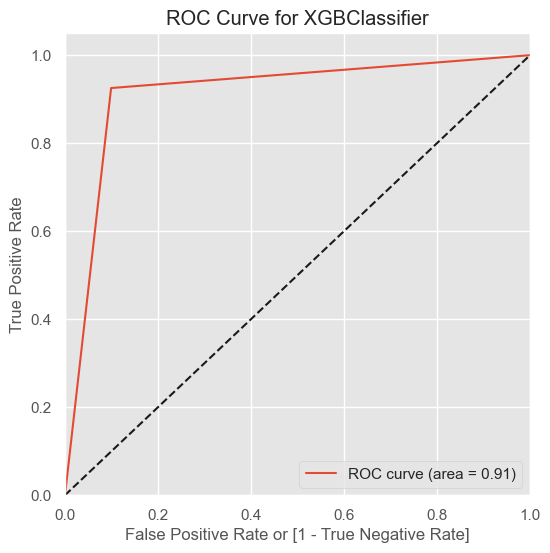

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.84  ...           0.84               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00
4               KNN            0.99  ...           0.92               0.00
5           XGBoost            0.90  ...           0.90               0.00

[6 rows x 11 columns]

In [449]:
# Running model against training + collect results
accuracy_test, cnf_matrix_test, f1_test = model_eval(xgb_model, X_feat_test, y_feat_test)
print("Accuracy on test data:", accuracy_test)
print("Confusion Matrix on test data:\n", cnf_matrix_test)
print("f1 test:",f1_test)

# Store results
temp = store_results("XGBoost", y_feat_train, X_feat_train, y_feat_test, X_feat_test, xgb_model, 5)

# Plot ROC curve
draw_roc(xgb_model, X_feat_test, y_feat_test)

# Append results to the outcome DataFrame
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

### Bagging Classifier


In [450]:
from sklearn.ensemble import BaggingClassifier
Bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
Bagging_model.fit(X_feat_train, y_feat_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

Accuracy on test data: 0.93669
Confusion Matrix on test data:
 [[81866  1974]
 [ 4357 11803]]
f1 test: 0.7885225640511743


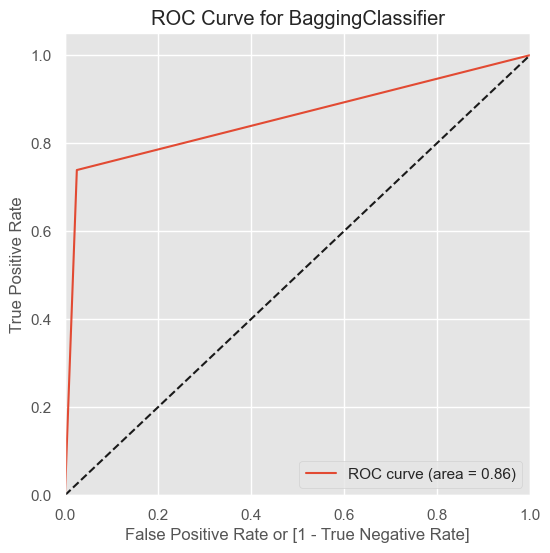

Model  Accuracy_train  ...  CrossVal_Mean  CrossVal_Variance
0  Dummy classifier            0.83  ...           0.83               0.00
1   logistic regres            0.84  ...           0.84               0.00
2     Decision Tree            0.99  ...           0.91               0.00
3     Random Forest            0.99  ...           0.93               0.00
4               KNN            0.99  ...           0.92               0.00
5           XGBoost            0.90  ...           0.90               0.00
6           Bagging            0.98  ...           0.93               0.00

[7 rows x 11 columns]

In [451]:
# Running model against training + collect results
accuracy_test, cnf_matrix_test, f1_test = model_eval(Bagging_model, X_feat_test, y_feat_test)
print("Accuracy on test data:", accuracy_test)
print("Confusion Matrix on test data:\n", cnf_matrix_test)
print("f1 test:",f1_test)

# Store results in the outcome DataFrame
temp = store_results("Bagging", y_feat_train, X_feat_train, y_feat_test, X_feat_test, Bagging_model, 5)

# Plot the ROC curve
draw_roc(Bagging_model, X_feat_test, y_feat_test)

# Append results to the outcome DataFrame
outcome = pd.concat([outcome, temp], ignore_index=True)
outcome

## Analysis

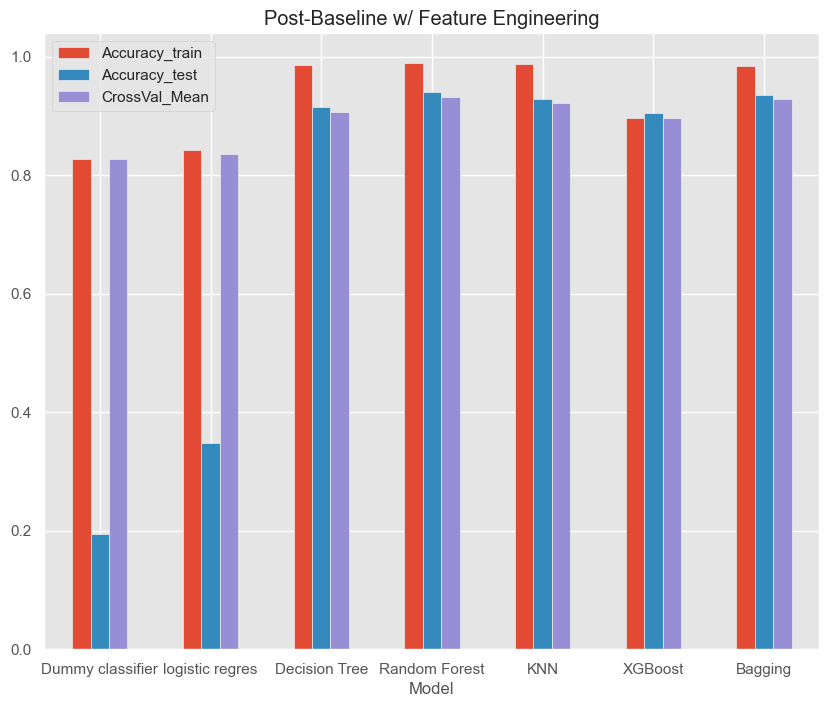

In [453]:
# Conclusion for imbalanced data
plt.rcParams["figure.figsize"] = (10, 8)
outcome.plot(x='Model', y=['Accuracy_train', 'Accuracy_test', 'CrossVal_Mean'], kind="bar")
plt.title("Post-Baseline w/ Feature Engineering")
plt.xticks(rotation=0) 
plt.show()